# import data

In [257]:
import pandas as pd
import numpy as np
import scipy
from scipy.sparse import load_npz,save_npz
import datetime
import re
import matplotlib.pyplot as plt
from glob import glob
from missingno import matrix
from pyproj import Transformer
from IPython.display import display
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import *
# import wandb

from numpy.lib.stride_tricks import sliding_window_view
import wradlib as wrl
import os

# os.environ["WANDB_SILENT"] = "True"
# wandb.login()

In [258]:
# URLS
URL_gauge_data = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges/'
URL_gauge_2020_file = URL_gauge_data + 'clean2020data1475.csv'
URL_saved_sensor_data = URL_gauge_data + 'hbs_lysigogn.csv'
DIR_data = 'C:/Users/sverrirhd/vedurgogn/'
DIR_rain_gauges = glob(URL_gauge_data + '*cleaned*')

In [259]:
# Rain gauge metadata
df_sensors = pd.read_csv(URL_saved_sensor_data, sep='\t', encoding='Windows-1252')
## Raw rain gauge data
rain_gauage_ids = [re.findall('[0-9][0-9][0-9][0-9]',i)[0] for i in DIR_rain_gauges]
gauges_raw = pd.DataFrame([pd.read_pickle(i) for i in DIR_rain_gauges],index = rain_gauage_ids).T
gauges_raw = gauges_raw.loc[:,['1473','1475','1481','1485']]
gauges_raw_hour = gauges_raw.resample('1h').agg(pd.Series.sum, skipna=False)
# Processed rain gauge data
gauges_clean_long = pd.read_csv(URL_gauge_data + 'yfirfarid_hbs.csv',sep='\t')
gauges_clean_long.TIMI = pd.to_datetime(gauges_clean_long.TIMI)
gauges_clean = gauges_clean_long.pivot_table(values='R',index='TIMI',columns='STOD')
gauges_clean.columns = [str(i) + '_clean' for i in gauges_clean.columns]
# All rain gauge data 
gauges = pd.concat([gauges_raw_hour,gauges_clean],axis=1)
# Drainage flow data
df_target = pd.read_pickle('../../Drainage data/all_drainage_data_uncorrected.pkl')

In [260]:
# Drainage flow data
df_target = pd.read_pickle('../../Drainage data/all_drainage_data_corrected.pkl')

In [261]:
dt_start = datetime.datetime(2020,1,1,0,0,0)
dt_end = datetime.datetime(2020,12,31,23,59,59)
new_index = pd.date_range(dt_start,dt_end, freq='1h')
# df_map = pd.read_pickle('../14times18_CAPPI_raw').resample('1h').sum()
df_map = pd.read_pickle('../40times60_CAPPI_raw_echo')#.resample('1h').sum()
# df_map = df_map.resample('1h').sum().reindex(new_index)
# H,W = 14,18
H,W = 40,60


# process rain-gauge data

In [262]:
# Replace all 0 with nan, drop all nan, reindex and then fill nan with 0 (Cuts away all the 0 from the start)
full_index = pd.date_range(gauges_raw_hour.index.min(),gauges.index.max(),freq='1h')
processed_gauges = gauges.copy()
for gauge in gauges:
    first_non_zero_index = processed_gauges.loc[:,gauge].mask(lambda x : x == 0).first_valid_index()
    processed_gauges.loc[:first_non_zero_index,gauge] = np.nan
    # plt.plot(processed_gauges.loc[:,gauge])
    # plt.title(gauge)
    # plt.show()

In [263]:
def correlate(a,b,lag):
    al = np.roll(a.values.ravel(),lag)
    bl = b.values.ravel()
    return np.corrcoef(al,bl)[0,1]

def pair_lag_correlations(X,Y,lag_values):
    first_non_0_X = X[(X != 0) & ~(X.isna())].index[0]
    first_non_0_Y = Y[(Y != 0) & ~(Y.isna())].index[0]
    first_non_0 = np.max([first_non_0_X,first_non_0_Y])
    # Transformation
    Yh = Y.resample('1h').sum().loc[first_non_0:]
    Xh = X.resample('1h').sum().loc[first_non_0:]
    common_index = Xh.index.intersection(Yh.index)
    Xhc = Xh.loc[common_index]
    Yhc = Yh.loc[common_index]
    
    # Correlation
    corrs = []
    for l in lag_values:
        c_tmp = correlate(Xhc,Yhc,l)
        corrs.append(c_tmp)
    return corrs

In [264]:
transformer_gps_isl = Transformer.from_crs("epsg:4326", "epsg:3057" ) # Umbreyta GPS staðsetningu yfir í cartesian hnit fyrir Ísland
transformer_isl_gps = Transformer.from_crs("epsg:3057", "epsg:4326") # Umbreyta cartesian hnitum aftur í GPS hnit
sensor_coords = [transformer_gps_isl.transform(b,a) for a,b in zip(df_sensors.BREIDD_Y,df_sensors.LENGD_X)]
sensor_coords = np.array(sensor_coords)
df_sensors.loc[:,'gpsx'] = sensor_coords[:,0]
df_sensors.loc[:,'gpsy'] = sensor_coords[:,1]

# Let's use 1473 to predict for GEL


In [265]:
# Model
lag = 168*2

def get_x_y_with_lag(lag,
                     input_data = gauges.loc[:,'1473'].resample('1h').sum(),
                     output_data = df_target.loc[:,'RVK-GEL'].resample('1h').sum(),
                     dt_start = datetime.datetime(2014,1,1,0,0,0),
                     dt_end = datetime.datetime(2020,12,31,23,59,59)):
    
    new_index = pd.date_range(dt_start,dt_end, freq='1h')
    common_index = input_data.index.intersection(output_data.index)
    
    # remove missing data
    input_data = input_data.loc[common_index]
    output_data = output_data.loc[common_index]
    input_data = input_data.dropna()
    output_data = output_data.dropna()
    # Replace with nan values in both datasets
    input_data = input_data.reindex(new_index)
    output_data = output_data.reindex(new_index)

    # Sliding window
    output_sequences = sliding_window_view(output_data,(lag)).squeeze()[:,-1]
    if (len(input_data.shape) == 1) or (input_data.shape[-1] == 1):
        rainfall_input_sequences = sliding_window_view(input_data,(lag)).reshape((-1,lag))
    else:
        rainfall_input_sequences = sliding_window_view(input_data,(lag,input_data.shape[-1])).reshape((-1,lag,input_data.shape[-1]))

    return rainfall_input_sequences,output_sequences.reshape(-1,1)


# Radar-rainfall function

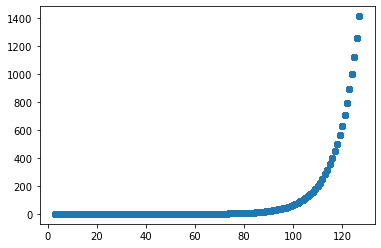

In [690]:
plt.scatter(age,wrl.trafo.idecibel(offset + gain * age))

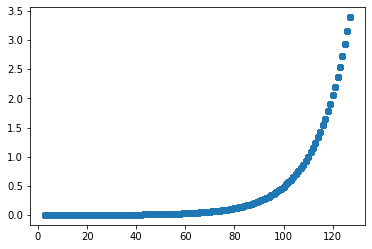

In [692]:
plt.scatter(age,wrl.zr.z_to_r(wrl.trafo.idecibel(offset + gain * age), a=200, b=1.6))

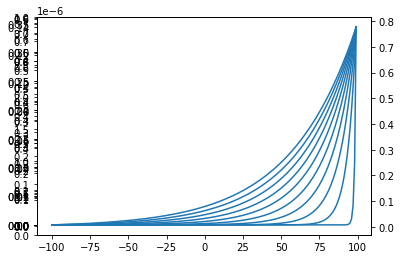

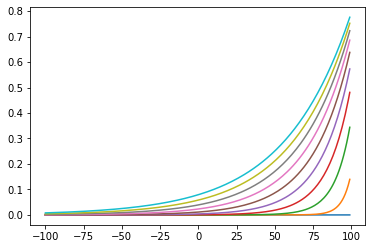

In [266]:

def to_rainfall(radar_data, b = 1.6, a = 200):
    gain,offset = (0.5, -32.0)
    return wrl.zr.z_to_r(wrl.trafo.idecibel(offset + gain * radar_data), a=a, b=b)


x = np.arange(-100,100)
for b in np.linspace(0.1,5,10):
    y = to_rainfall(x,b)
    plt.plot(x,y)
plt.show()
    

In [267]:
from scipy.optimize import minimize

In [796]:
df_map_tmp

2020-01-04 11:00:00     12.800000
2020-01-04 12:00:00     24.500000
2020-01-04 13:00:00    107.666667
2020-01-04 14:00:00     72.250000
2020-01-04 15:00:00     29.833333
                          ...    
2020-12-31 19:00:00     21.916667
2020-12-31 20:00:00     26.916667
2020-12-31 21:00:00     17.363636
2020-12-31 22:00:00     28.000000
2020-12-31 23:00:00      8.000000
Freq: H, Name: 1172, Length: 8701, dtype: float64

0.6657527606943849


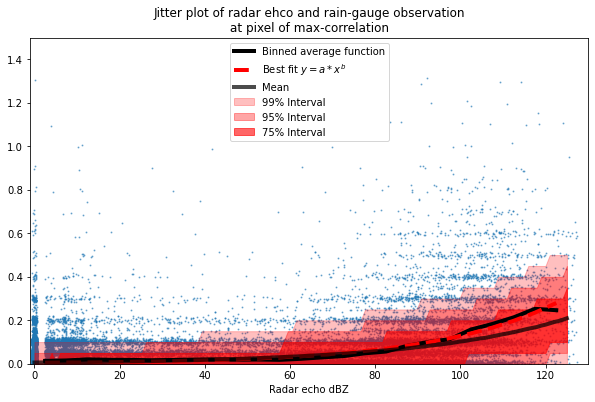

(0.00015719075335099585, array([3.32400429e+00, 5.81538508e+04]))

In [804]:
def f_shape(pixel,shift,low = 0,high = 125,intervals = 5):
    df_gauge_pixel = pd.concat([
        df_map.iloc[:,pixel].shift(shift),
        gauges_raw.loc[df_map.index,'1475']],
                               axis=1)
    bins = np.c_[np.arange(low,high-intervals,intervals),np.arange(low + intervals,high,intervals)]
    bin_centres = bins.mean(axis=1)
    bin_means = []
    for l,h in bins:
        mean_value = df_gauge_pixel.loc[(df_gauge_pixel.loc[:,pixel] > l) & (df_gauge_pixel.loc[:,pixel] <= h),'1475'].mean()
        if np.isnan(mean_value):
            mean_value = 0
        bin_means.append(mean_value)
    return bin_centres,bin_means


def quick_corr(pixel,shift,low = 0,high = 125,intervals = 5):
    df_gauge_pixel = pd.concat([
        df_map.iloc[:,pixel].shift(shift),
        gauges_raw.loc[df_map.index,'1475']],
                               axis=1)

    bins = np.c_[np.arange(low,high-intervals,intervals),np.arange(low + intervals,high,intervals)]
    bin_centres,bin_means = f_shape(pixel,shift,low,high,intervals)
        
    loss = lambda params : np.mean((to_rainfall(bin_centres, b = params[0], a = params[1]) -  bin_means)**2)

    results = minimize(loss, (1.6, 200), bounds=[(0.1,10),(1,100000000)])
    
    y_pred =  to_rainfall(df_map.iloc[:,pixel].shift(shift),
                          results.x[0],results.x[1])

    
    corr_tmp = y_pred.resample('1h').mean().corr(gauges_raw.loc[df_map.index,'1475'].resample('1h').mean())
    return corr_tmp

low = 0
high = 130
intervals = 5
pixel = 1172 

shift_values = np.arange(-10,10)
shift = 0

# for shift in shift_values:
corr = quick_corr(pixel ,shift, low, high, intervals)
print(corr)



# y = to_rainfall(bin_centres,b)
df_gauge_pixel = pd.concat([
    df_map.iloc[:,pixel].shift(shift),
    gauges_raw.loc[df_map.index,'1475']],
                            axis=1)
    
loss = lambda params : np.mean((to_rainfall(bin_centres, b = params[0], a = params[1]) -  bin_means)**2)
results = minimize(loss, (1.6, 200), bounds=[(0.1,10),(1,100000000)])


plt.figure(figsize=(10,6))
# binned average
bin_centres,bin_means = f_shape(pixel,shift, low, high, intervals)       
plt.plot(bin_centres,bin_means,color='black',linewidth=4,label='Binned average function')

# best fit to binned average
y_pred = to_rainfall(bin_centres,results.x[0],results.x[1])
plt.plot(bin_centres,y_pred,'--',color='red',linewidth=4,label='Best fit $y = a*x^b$')

# jitter plot
plt.scatter(df_map.iloc[:,pixel].shift(shift) + np.random.uniform(-0.5,0.5,gauges_raw.loc[df_map.index,'1475'].shape),
            gauges_raw.loc[df_map.index,'1475'] + np.random.normal(0,0.01,gauges_raw.loc[df_map.index,'1475'].shape),
            s=1, alpha = 0.5)
plot_predictions(plt.gca(), age_pred, t_samples.T*(1/20), num_samples=0, legend=True, title='Prediction distribution $t_*|\mathbf{t}$')

plt.xlim(-1,130)
plt.ylim(0,1.5)
plt.title('Jitter plot of radar ehco and rain-gauge observation\n at pixel of max-correlation ')
plt.xlabel('Radar echo dBZ')
plt.legend()
plt.show()

results.fun, results.x


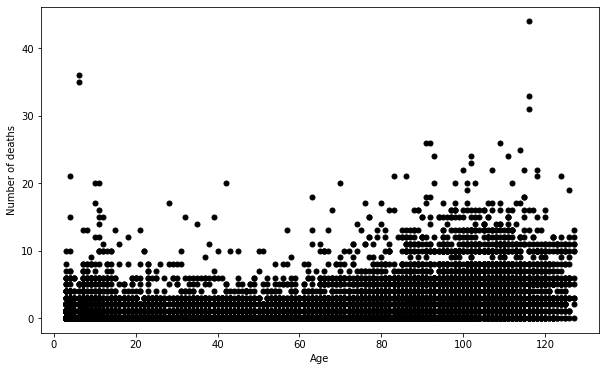

In [713]:
###################################################
# Raw data
###################################################

# The input covariate is age
age = df_map.iloc[:,pixel].shift(shift).values
# age = 10.0 ** (age / 10.0)
n_subset = 1000000
subset = np.random.choice(len(age),n_subset)

# The output is the number of deaths in the study popular for each age
deaths =  gauges_raw.loc[df_map.index,'1475'].values

# age = age[subset]
# deaths = deaths[subset]
deaths = (deaths * 20).astype(int)

# more_than_0 = age > 20
more_than_0 = (deaths > -1) & (age > 0) & ~(np.isnan(deaths)) & ~(np.isnan(age))


age = age[more_than_0]
deaths = deaths[more_than_0]



# number of data points
N = len(deaths)

# Let's standardize the input covariate and prepare 
m_age = np.mean(age)
s_age = np.std(age)
standardize = lambda x: (x-m_age)/s_age

# prep data
X = standardize(age)
X = X[:, None]
t = age[:, None]

# Define input points for prediction
age_pred = np.linspace(0, 125, 125)
Xp = standardize(age_pred)

# Let's set-up the design matrix for the training data and the inputs for predictions
design_matrix = lambda x: np.column_stack((np.ones(len(x)), x))
X_train = design_matrix(X)
X_pred = design_matrix(Xp)

# Plotting
def plot_data(ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
    ax.plot(age, deaths, 'k.', markersize=10)
    ax.set_xlabel('Age')
    ax.set_ylabel('Number of deaths')
    
    # ax.set_xlim((25, 70))
    # ax.set_ylim((-2, 25))


plot_data()

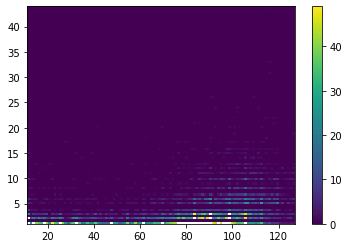

In [737]:
subset = (age>10) & (deaths > 0) 
plt.hist2d(age[subset],deaths[subset],bins = 100,cmax = 50)
plt.colorbar()
plt.show()

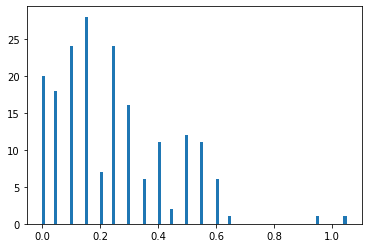

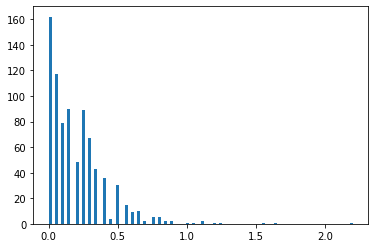

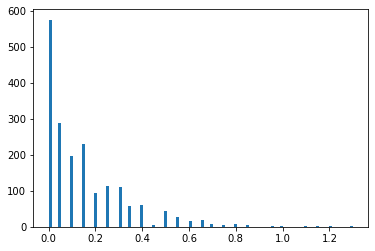

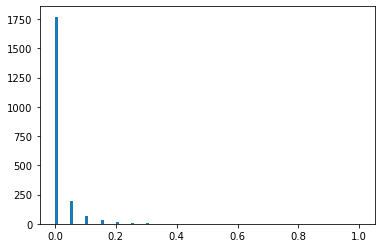

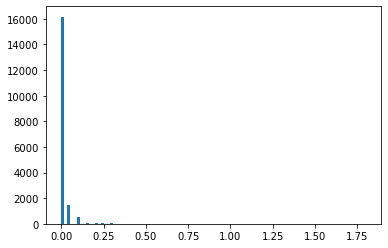

In [721]:
tmp_slice = deaths[(age > 120) & (age <130)]
plt.hist(tmp_slice/20,bins = 100)
plt.show()
tmp_slice = deaths[(age > 110) & (age <120)]
plt.hist(tmp_slice/20,bins = 100)
plt.show()

tmp_slice = deaths[(age > 100) & (age <110)]
plt.hist(tmp_slice/20,bins = 100)
plt.show()

tmp_slice = deaths[(age > 40) & (age <50)]
plt.hist(tmp_slice/20,bins = 100)
plt.show()

tmp_slice = deaths[(age > 0) & (age <10)]
plt.hist(tmp_slice/20,bins = 100)
plt.show()

In [718]:
def metropolis(log_joint, num_params, tau, max_itt, theta_init=None, seed=None):    
    
    # uncomment if progress bar is causing issues
    # tqdm._instances.clear()
    
    if seed is not None:
        np.random.seed(seed)

    if theta_init is None:
        theta_init = np.zeros((num_params))
    
    # prepare lists 
    thetas = [theta_init]
    accepts = []
    log_p_theta = log_joint(theta_init)
    
    for k in tqdm(range(max_itt)):

        # get the last value for theta and generate new proposal candidate
        theta_cur = thetas[-1]
        theta_star = theta_cur + np.random.normal(0, tau, size=(num_params))
        
        # evaluate the log density for the candidate sample
        log_p_theta_star = log_joint(theta_star)

        # compute acceptance probability
        log_r = log_p_theta_star - log_p_theta
        A = min(1, np.exp(log_r))
        # print(np.exp(log_r),log_r,log_p_theta_star, log_p_theta, theta_cur,theta_star)
        # accept new candidate with probability A
        if np.random.uniform() < A:
            theta_next = theta_star
            log_p_theta = log_p_theta_star
            accepts.append(1)
        else:
            theta_next = theta_cur
            accepts.append(0)

        thetas.append(theta_next)
        
    print('Acceptance ratio: %3.2f' % np.mean(accepts))
        
    thetas = np.stack(thetas)
    return thetas
from scipy.stats import expon
from scipy.stats import multivariate_normal as mvn
from scipy.stats import poisson
from tqdm import tqdm

npdf = lambda x, m, v: np.exp(-(x-m)**2/(2*v))/np.sqrt(2*np.pi*v)
half_npdf = lambda x, m, v: 2*np.exp(-(x-m)**2/(2*v))/np.sqrt(2*np.pi*v)
log_npdf = lambda x, m, v: -0.5*(x-m)**2/(v) - 0.5*np.log(2*np.pi*v)
log_half_npdf = lambda x, m, v: np.log(2) -0.5*(x-m)**2/(v) - 0.5*np.log(2*np.pi*v)

laplace = lambda x: 0.5*np.exp(- np.abs(x))
log_laplace = lambda x: np.log(0.5) - np.abs(x)


In [719]:
num_params = 3

def log_joint_poisson(theta):
    
    # theta is 3 dimensional, the first two entries represent to weights and the last represents eta = log(kappa^2)
    w = theta[:2]
    kappa2 = np.exp(theta[2])
    
    # log hyperprior and change-of-variable term
    log_hyperprior = log_half_npdf(kappa2, 0, 1) + theta[2]
    
    # log prior
    log_prior = np.sum(log_npdf(w, 0, kappa2))
    
    # log likelihood
    y = X_train@w
    mu = np.exp(y)
    log_likelihood = np.sum(poisson.logpmf(deaths, mu))
    # print(log_likelihood, log_prior, log_hyperprior)
    return log_likelihood + log_prior + log_hyperprior


    
    

In [720]:

max_iter = 50000
warm_up = int(0.5*max_iter)

thetas_poisson = metropolis(log_joint_poisson, num_params, 0.01, max_itt=max_iter)

# get rid of warm-up samples
thetas_poisson = thetas_poisson[warm_up:, :]

  0%|          | 0/50000 [00:00<?, ?it/s]C:\Users\SVERRI~1\AppData\Local\Temp/ipykernel_1112/2160134000.py:28: RuntimeWarning: overflow encountered in exp
  A = min(1, np.exp(log_r))
100%|██████████| 50000/50000 [02:19<00:00, 357.63it/s]

Acceptance ratio: 0.31


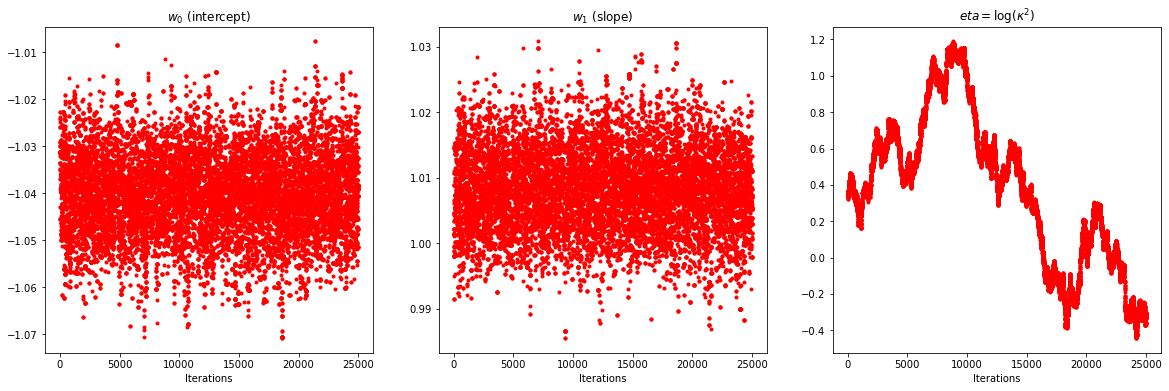

In [610]:
# extract
w_samples = thetas_poisson[:, :2]
eta_samples = thetas_poisson[:, 2]

# transform
kappa2_samples = np.exp(eta_samples)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].plot(w_samples[:, 0], 'r.')
axes[0].set_title('$w_0$ (intercept)')

axes[1].plot(w_samples[:, 1], 'r.')
axes[1].set_title('$w_1$ (slope)')

axes[2].plot(eta_samples, 'r.')
axes[2].set_title('$eta = \log(\kappa^2)$')

for i in range(3):
    axes[i].set_xlabel('Iterations')


**************************************************
kappa2         		Mean	Std. dev.
**************************************************
Prior			0.79	0.60
Posterior		1.59	0.66


**************************************************
w0             		Mean	Std. dev.
**************************************************
Prior			0.00	0.87
Posterior		-1.04	0.01


**************************************************
w1             		Mean	Std. dev.
**************************************************
Prior			-0.00	0.88
Posterior		1.01	0.01



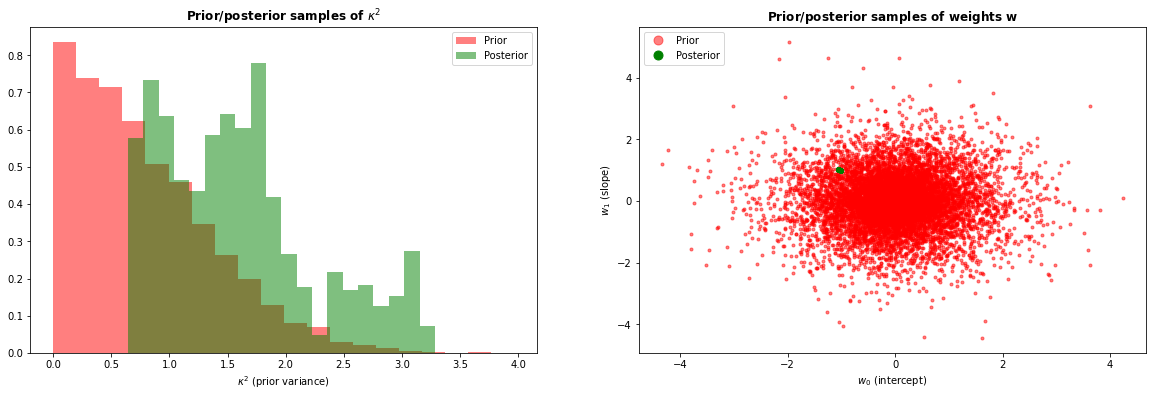

In [611]:
# number of samples
S = 10000

# generate samples for kappa2 (w)
kappa2_prior_samples = np.abs(np.random.normal(0, 1, size=S))

w_prior_samples = np.sqrt(kappa2_prior_samples)[:, None]*np.random.normal(0, 1, size=(S, 2))


fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# samples of kappa^2
axes[0].hist(kappa2_prior_samples, 20, density=True, color='r', alpha=0.5, label='Prior')
axes[0].hist(kappa2_samples, 20, density=True, color='g', alpha=0.5, label='Posterior',  )

axes[0].set_xlabel('$\kappa^2$ (prior variance)')
axes[0].set_title('Prior/posterior samples of $\kappa^2$', fontweight='bold')
axes[0].legend()



# samples of w
axes[1].plot(w_prior_samples[:, 0], w_prior_samples[:, 1], 'r.', alpha=0.5, label='Prior')
axes[1].plot(w_samples[:, 0], w_samples[:, 1], 'g.', label='Posterior')
axes[1].legend(loc='upper left', markerscale=3)

axes[1].set_xlabel('$w_0$ (intercept)')
axes[1].set_ylabel('$w_1$ (slope)')
axes[1].set_title('Prior/posterior samples of weights $\mathbf{w}$', fontweight='bold');

def print_summary(prior_samples, posterior_samples, name):
    print('')
    print(50*'*')
    print('%-15s\t\tMean\tStd. dev.' % name)
    print(50*'*')
    print('Prior\t\t\t%3.2f\t%3.2f' % (np.mean(prior_samples), np.std(prior_samples)))
    print('Posterior\t\t%3.2f\t%3.2f' % (np.mean(posterior_samples), np.std(posterior_samples)))
    print('')

# print prior and posterior summaries
print_summary(kappa2_prior_samples, kappa2_samples, 'kappa2')
print_summary(w_prior_samples[:, 0], w_samples[:, 0], 'w0')
print_summary(w_prior_samples[:, 1], w_samples[:, 1], 'w1')



In [612]:
print('Probability of the event: w1 > 0')
print(50*'-')
print('Prior probability:\t%3.2f' % np.mean(w_prior_samples[:, 1] > 0))
print('Posterior probability:\t%3.2f' % np.mean(w_samples[:, 1] > 0))

Probability of the event: w1 > 0
--------------------------------------------------
Prior probability:	0.50
Posterior probability:	1.00


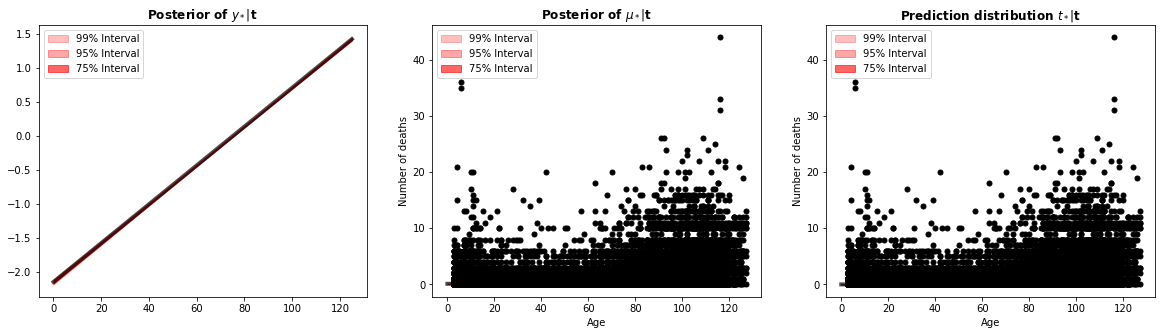

In [635]:
import numpy as np
import pylab as plt

def eval_density_grid(density_fun, P=100):
    x_grid = np.linspace(-7, 7, 100)
    X1, X2 = np.meshgrid(x_grid, x_grid)
    XX = np.column_stack((X1.ravel(), X2.ravel()))
    return x_grid, density_fun(XX).reshape((P, P))

def plot_summary(ax, x, s, interval=95, num_samples=100, sample_color='k', sample_alpha=0.4, interval_alpha=0.25, color='r', legend=True, title="", plot_mean=True, plot_median=False, label="", seed=0):
    
    b = 0.5*(100 - interval)
    
    lower = np.percentile(s, b, axis=0).T
    upper = np.percentile(s, 100-b, axis=0).T
    
    if plot_median:
        median = np.percentile(s, [50], axis=0).T
        lab = 'Median'
        if len(label) > 0:
            lab += " %s" % label
        ax.plot(x.ravel(), median, label=lab, color=color, linewidth=4)
        
    if plot_mean:
        mean = np.mean(s, axis=0).T
        lab = 'Mean'
        if len(label) > 0:
            lab += " %s" % label
        ax.plot(x.ravel(), mean, '--', label=lab, color=color, linewidth=4)
    ax.fill_between(x.ravel(), lower.ravel(), upper.ravel(), color=color, alpha=interval_alpha, label='%d%% Interval' % interval)    
    
    if num_samples > 0:
        np.random.seed(seed)
        idx_samples = np.random.choice(range(len(s)), size=num_samples, replace=False)
        ax.plot(x, s[idx_samples, :].T, color=sample_color, alpha=sample_alpha);
    
    if legend:
        ax.legend(loc='best')
        
    if len(title) > 0:
        ax.title(title, fontweight='bold')
    
def plot_predictions(ax, x, s, num_samples=100, sample_color='k', sample_alpha=0.4, color='r', legend=False, plot_median=False, plot_mean=True, seed=123, title=''):

    plot_summary(ax, x, s, color=color, interval=99, num_samples=0, interval_alpha=0.25, plot_mean=False, plot_median=False, legend=legend, seed=seed)
    plot_summary(ax, x, s, color=color, interval=95, num_samples=0, sample_alpha=0.1, interval_alpha=0.35, plot_mean=False, plot_median=False, legend=legend, seed=seed)
    plot_summary(ax, x, s, color=color, interval=75, interval_alpha=0.6, num_samples=num_samples, sample_alpha=sample_alpha, plot_mean=False, plot_median=False, legend=legend, seed=seed, sample_color=sample_color)
    
    if plot_median:
        median = np.percentile(s, [50], axis=0).T
        ax.plot(x.ravel(), median, label='Median', color='k', linewidth=4, alpha=0.7)
        
    if plot_mean:
        mean = np.mean(s, axis=0).T
        ax.plot(x.ravel(), mean, '-', label='Mean', color='k', linewidth=4, alpha=0.7)
        
    if title:
        ax.set_title(title, fontweight='bold')

# making predictions by mapping the posterior samples of (w, kappa^2) through the model
f_samples = X_pred@w_samples.T
mu_samples = np.exp(f_samples)

# max_value = 10000000
# mu_samples[mu_samples > max_value] = max_value 
t_samples = np.random.poisson(mu_samples)

# plot
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plot_predictions(axes[0], age_pred, f_samples.T, num_samples=0, legend=True, title='Posterior of $y_*|\mathbf{t}$')
plot_predictions(axes[1], age_pred, mu_samples.T, num_samples=0, legend=True, title='Posterior of $\mu_*|\mathbf{t}$')
plot_predictions(axes[2], age_pred, t_samples.T*(1/20), num_samples=0, legend=True, title='Prediction distribution $t_*|\mathbf{t}$')
plot_data(axes[1])
plot_data(axes[2])



In [422]:
corrs = []
best_corr = 0 
best_corr_idx = -1

In [423]:

for i in range(2400):
    
    corr = quick_corr(i,shift, low, high, intervals)
    corrs.append(corr)
    if best_corr < corr:
        best_corr = corr
        best_corr_idx = i
        
        print('new best correlation:', best_corr_idx,corr)


new best correlation: 0 0.4616186272356756
new best correlation: 3 0.4817737673235387
new best correlation: 7 0.4866694973173414
new best correlation: 8 0.4885199640591229
new best correlation: 9 0.5179016827668937
new best correlation: 19 0.5384223020912456
new best correlation: 21 0.5481750740261708
new best correlation: 22 0.5664760330302816
new best correlation: 23 0.5672771973039034
new best correlation: 24 0.5687556133602177


KeyboardInterrupt: 

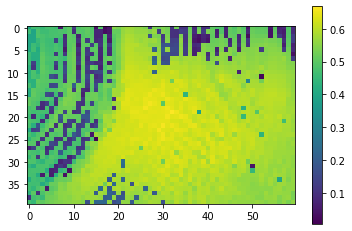

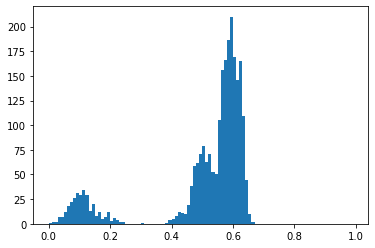

In [255]:
plt.imshow(np.array(corrs).reshape(H,W))
plt.colorbar()
plt.show()
plt.hist(corrs,bins=np.arange(0,1,0.01))
plt.show()

(-10.0, 120.0)

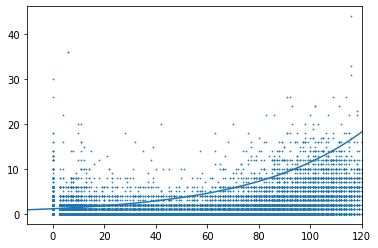

In [621]:
plt.scatter(df_map.iloc[:,pixel],
            gauges_raw.loc[df_map.index,'1475']*20,
            s = 0.5)



x = np.arange(-10,150)
y = to_rainfall(x,b,a)
# for b in np.linspace(0.5,3,10):
#     y = to_rainfall(x,b)
plt.plot(x,y*20)
# plt.plot()
# plt.ylim(-0.1,2)
plt.xlim(-10,120)

# optimizing correlation with rain_gauge


In [ ]:
# for b in np.linspace(1,2.5,10):
#     mean_of_rainfall = to_rainfall(df_map,b).resample('1h').mean()

#     # tmp_target = df_target.loc[:,'RVK-GEL'].resample('1h').sum().reindex(mean_of_rainfall.index)
#     tmp_target_2 = gauges.loc[:,'1475'].resample('1h').sum().reindex(mean_of_rainfall.index)
#     # correlations1 = mean_of_rainfall.shift(1).interpolate().apply(lambda x : x.corr(tmp_target))
#     correlations2 = mean_of_rainfall.shift(1).interpolate().apply(lambda x : x.corr(tmp_target_2))

#     print('coeff:',b,'shift1corr:',correlations1.max())
#     print('coeff:',b,'shift2corr:',correlations2.max())

In [191]:
# for b in np.linspace(1,2.5,10):
mean_of_rainfall = to_rainfall(df_map,b = b, a = a).resample('1h').mean()

tmp_target = df_target.loc[:,'RVK-GEL'].resample('1h').sum().reindex(mean_of_rainfall.index)
tmp_target_2 = gauges.loc[:,'1475'].resample('1h').sum().reindex(mean_of_rainfall.index)
correlations1 = mean_of_rainfall.shift(0).interpolate().apply(lambda x : x.corr(tmp_target))
correlations2 = mean_of_rainfall.shift(0).interpolate().apply(lambda x : x.corr(tmp_target_2))

print('coeff:',b,'shift1corr:',correlations1.max())
print('coeff:',b,'shift2corr:',correlations2.max())

coeff: 1.6 shift1corr: 0.4550739041870652
coeff: 1.6 shift2corr: 0.6683773682415717


In [87]:
# tmp_target.corr(tmp_target_2)

0.623852508055172

In [88]:
for b in np.linspace(2.5,4,10):
    mean_of_rainfall = to_rainfall(df_map,b).resample('1h').mean()

    tmp_target = df_target.loc[:,'RVK-GEL'].resample('1h').sum().reindex(mean_of_rainfall.index)
    tmp_target_2 = gauges.loc[:,'1475_clean'].resample('1h').sum().reindex(mean_of_rainfall.index)
    correlations1 = mean_of_rainfall.shift(1).interpolate().apply(lambda x : x.corr(tmp_target))
    correlations2 = mean_of_rainfall.shift(1).interpolate().apply(lambda x : x.corr(tmp_target_2))

    print('coeff:',b,'shift1corr:',correlations1.max())
    print('coeff:',b,'shift2corr:',correlations2.max())

coeff: 2.5 shift1corr: 0.5168657889862828
coeff: 2.5 shift2corr: 0.7126502576522699
coeff: 2.6666666666666665 shift1corr: 0.5186966410847388
coeff: 2.6666666666666665 shift2corr: 0.7100324110872309
coeff: 2.8333333333333335 shift1corr: 0.5197603768418884
coeff: 2.8333333333333335 shift2corr: 0.7069576494146952
coeff: 3.0 shift1corr: 0.5206821047622514
coeff: 3.0 shift2corr: 0.7036050196310449
coeff: 3.1666666666666665 shift1corr: 0.5219237151926887
coeff: 3.1666666666666665 shift2corr: 0.7001029913336391
coeff: 3.333333333333333 shift1corr: 0.5227958408690573
coeff: 3.333333333333333 shift2corr: 0.6965429706834629
coeff: 3.5 shift1corr: 0.5233738689737183
coeff: 3.5 shift2corr: 0.6929892675109484
coeff: 3.6666666666666665 shift1corr: 0.5237178191297532
coeff: 3.6666666666666665 shift2corr: 0.6894864246564038
coeff: 3.833333333333333 shift1corr: 0.5238755861618697
coeff: 3.833333333333333 shift2corr: 0.6860645980204376
coeff: 4.0 shift1corr: 0.523885475738368
coeff: 4.0 shift2corr: 0.68

In [ ]:
def to_rainfall(radar_data, b = 1.6):
    return wrl.zr.z_to_r(wrl.trafo.idecibel(offset + gain * radar_data), a=200, b=b)


,1473,1475,1481,1485,1473_clean,1474_clean,1475_clean,1478_clean,1485_clean
2020-01-01 00:00:00,0.25,0.40,0.60,6.95,0.0,0.1,0.0,0.0,0.0
2020-01-01 01:00:00,0.15,0.20,1.40,3.50,0.2,0.2,0.2,0.0,1.0
2020-01-01 02:00:00,0.00,0.80,0.05,3.75,0.0,0.2,0.1,0.0,0.0
2020-01-01 03:00:00,0.00,0.40,0.15,2.00,0.0,0.1,0.2,0.0,0.0
2020-01-01 04:00:00,0.10,0.20,0.00,5.55,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,0.00,0.25,0.00,0.00,0.0,0.0,0.0,0.0,0.0
2020-12-31 20:00:00,0.00,0.15,0.00,0.40,0.0,0.0,0.0,0.0,0.0
2020-12-31 21:00:00,0.00,0.00,0.00,0.70,0.0,0.0,0.0,0.0,0.2
2020-12-31 22:00:00,0.00,0.00,0.00,0.50,0.0,0.0,0.0,0.0,0.5


In [113]:
df_map.resample('1h').mean().loc[:,0].corr(test_decibells.iloc[:,0])

0.4276765848001871

In [124]:
# gauges_tmp_target = gauges.resample('1h').sum().reindex(mean_of_rainfall.index)
# for b in np.linspace(0.1,1,20):
b = 0.5
test_decibells = wrl.zr.r_to_z(gauges_tmp_target, 200, b)
for col in test_decibells.columns:
    for shift in range(-2,20):
        print(shift,col,b,df_map.shift(shift).resample('1h').mean().apply(lambda x : x.corr(test_decibells.loc[:,col])).max())

-2 1473 0.5 0.5029343665237052
-1 1473 0.5 0.509628160964915
0 1473 0.5 0.5157544120380129
1 1473 0.5 0.5209937066070475
2 1473 0.5 0.524888036768334
3 1473 0.5 0.5280244345559458
4 1473 0.5 0.5292064428454034
5 1473 0.5 0.5290612245197107
6 1473 0.5 0.5280269754807103


KeyboardInterrupt: 

In [125]:
gauges_tmp_target = gauges.resample('1h').sum().reindex(mean_of_rainfall.index)
for b in np.linspace(0.1,1,20):
    test_decibells = wrl.zr.r_to_z(gauges_tmp_target, 200, b)
    for col in test_decibells.columns:
        print(col,b,df_map.shift(4).resample('1h').mean().apply(lambda x : x.corr(test_decibells.loc[:,col])).max())

1473 0.1 0.507724736804103
1475 0.1 0.36856026193972524
1481 0.1 0.5707676409969894
1485 0.1 0.47114514390600276
1473_clean 0.1 0.4421808468346189
1474_clean 0.1 0.581443017638103
1475_clean 0.1 0.5570500400569274
1478_clean 0.1 0.5294894715540206
1485_clean 0.1 0.5613181430623829
1473 0.1473684210526316 0.518596612459945
1475 0.1473684210526316 0.4013048652373473
1481 0.1473684210526316 0.5843292414973097
1485 0.1473684210526316 0.5131414380063174
1473_clean 0.1473684210526316 0.45032459370166067
1474_clean 0.1473684210526316 0.5924685739660813
1475_clean 0.1473684210526316 0.5683500084509238
1478_clean 0.1473684210526316 0.5373624685401932
1485_clean 0.1473684210526316 0.5777156986540412
1473 0.19473684210526315 0.527534426532707
1475 0.19473684210526315 0.43313802101078974
1481 0.19473684210526315 0.595761750737169
1485 0.19473684210526315 0.5481091795702464
1473_clean 0.19473684210526315 0.4582035685450027
1474_clean 0.19473684210526315 0.6020539151282037
1475_clean 0.1947368421052

KeyboardInterrupt: 

In [355]:
gauges_tmp_target = gauges.reindex(mean_of_rainfall.index)
b = 0.4
test_decibells = wrl.zr.r_to_z(gauges_tmp_target, 200, b)

for col in test_decibells.columns:
    correlations = df_map.shift(13).apply(lambda x : x.corr(test_decibells.loc[:,col]))
    print(col,b,correlations.max(),correlations.argmax())

1473 0.4 0.42719993020871716 23
1475 0.4 0.41544532469156953 741


KeyboardInterrupt: 

In [154]:
df_map.shift(13).resample('1h').mean().apply(lambda x : x.corr(test_decibells.loc[:,'1475_clean'])).argmax()

1409

In [353]:
Y = test_decibells.loc[:,'1485']
X = df_map.shift(3).loc[:,46]
to_rainfall(X).corr(gauges_tmp_target.loc[:,'1485'])

0.2596271689943807

In [338]:
Y = test_decibells.loc[:,'1485']
X = df_map.shift(13).loc[:,45]
to_rainfall(X).corr(gauges_tmp_target.loc[:,'1475_clean'])

0.37968259431345414

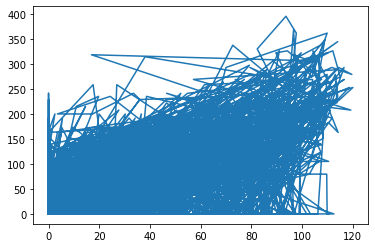

In [322]:
plt.plot(X,Y)

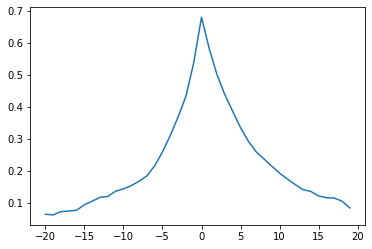

In [166]:
def pair_lag_correlations(X,Y,lag_values):
    first_non_0_X = X[(X != 0) & ~(X.isna())].index[0]
    first_non_0_Y = Y[(Y != 0) & ~(Y.isna())].index[0]
    first_non_0 = np.max([first_non_0_X,first_non_0_Y])
    # Transformation
    Yh = Y.resample('1h').sum().loc[first_non_0:]
    Xh = X.resample('1h').sum().loc[first_non_0:]
    common_index = Xh.index.intersection(Yh.index)
    Xhc = Xh.loc[common_index]
    Yhc = Yh.loc[common_index]
    
    # Correlation
    corrs = []
    for l in lag_values:
        c_tmp = correlate(Xhc,Yhc,l)
        corrs.append(c_tmp)
    return corrs

lag_values = range(-20,20)
correlations = pair_lag_correlations(X,Y,lag_values )
plt.plot(lag_values,correlations)

In [168]:
gauges

,1473,1475,1481,1485,1473_clean,1474_clean,1475_clean,1478_clean,1485_clean
TIMI,,,,,,,,,
2005-08-22 12:00:00,NaN,NaN,NaN,1.2,NaN,NaN,NaN,NaN,NaN
2005-08-22 13:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2005-08-22 14:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2005-08-22 15:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2005-08-22 16:00:00,NaN,NaN,NaN,0.2,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-06-03 09:00:00,0.0,0.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-03 10:00:00,0.0,0.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-03 11:00:00,0.0,0.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Index(['1473', '1475', '1481', '1485'], dtype='object')

0.6273654508993816

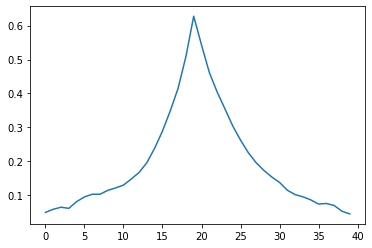

In [198]:
sensor_name = '1475'
pixel_id = 1409
shift = 14
b = 0.4

gauges_tmp_target = gauges_raw.loc[dt_start:dt_end]
test_decibells = wrl.zr.r_to_z(gauges_tmp_target, 200, b)
Y = test_decibells.loc[:,sensor_name]
X = df_map.shift(shift).loc[:,pixel_id]

correlations = pair_lag_correlations(X,Y,lag_values )
plt.plot(correlations)
max(correlations)


In [212]:
# pair_lag_correlations(X,Y,lag_values )
lag_values = np.arange(-3,3)
df_map.shift(shift).apply(lambda x : x.corr(Y)).max()

0.3637610040951244

In [214]:
correlation_dict = {}

In [301]:

# for b in np.linspace(0.2,0.6,5):
b = 0.41
gauges_tmp_target = gauges_raw.loc[dt_start:dt_end]
test_decibells = wrl.zr.r_to_z(gauges_tmp_target, 200, b)
for sensor_name in gauges_raw.columns:
    Y = test_decibells.loc[:,sensor_name].resample('1h').mean()

    shift = 2
    # for shift in np.arange(5,15):
    print((b,sensor_name,shift))
    X = df_map.shift(shift).resample('1h').mean()
    correlations = X.apply(lambda x : x.corr(Y))
    correlation_dict[(b,sensor_name,shift)] = correlations
    print(correlations.max())
    print(correlations.argmax())

(0.41, '1473', 2)
0.532065161669183
205
(0.41, '1475', 2)
0.6297524965362531
1234
(0.41, '1481', 2)
0.6288627550493051
1063
(0.41, '1485', 2)
0.6576595803726103
45


In [302]:
# df_map.loc[:,45]

In [317]:
X = df_map.loc[:,45]
Y = test_decibells.loc[:,sensor_name]


In [318]:
X.corr(Y)

0.5083458566208258

In [296]:
for b in np.linspace(0.1,6,15):
    rainfall = to_rainfall(X,b)
    target = gauges_tmp_target.loc[dt_start:dt_end,'1485']
    correlations1 = rainfall.shift(1).corr(target)

    print('coeff:',b,'shift1corr:',correlations1.max())

coeff: 0.1 shift1corr: 0.008646774641308396
coeff: 0.5214285714285715 shift1corr: 0.07463995830289773
coeff: 0.9428571428571428 shift1corr: 0.12792100780810342
coeff: 1.3642857142857143 shift1corr: 0.15222687254642614
coeff: 1.7857142857142858 shift1corr: 0.16223127512654792
coeff: 2.2071428571428573 shift1corr: 0.16603983835067165
coeff: 2.6285714285714286 shift1corr: 0.16721173635302553
coeff: 3.0500000000000003 shift1corr: 0.16726540283951968
coeff: 3.4714285714285715 shift1corr: 0.16685683755862502
coeff: 3.892857142857143 shift1corr: 0.16627511604455805
coeff: 4.314285714285714 shift1corr: 0.16564907601017487
coeff: 4.735714285714286 shift1corr: 0.1650355135581496
coeff: 5.157142857142857 shift1corr: 0.1644580543394831
coeff: 5.578571428571428 shift1corr: 0.16392485703154788
coeff: 6.0 shift1corr: 0.16343691017585293


In [297]:
# plt.plot(rainfall,target)

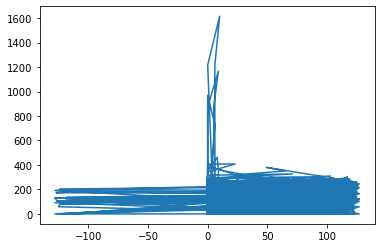

In [241]:
plt.plot(X,Y)


In [231]:
correlation_dict[(0.41, '1485', 2)].argmax()

45

In [218]:
(0.41, '1473', 2)
0.532065161669183
(0.41, '1475', 2)
0.6297524965362531
(0.41, '1481', 2)
0.6288627550493051
(0.41, '1485', 2)
0.6576595803726103

0.36202224225896656

In [140]:
print(col,b,df_map.shift(13).resample('1h').sum().apply(lambda x : x.corr(test_decibells.loc[:,col])).max())

1485_clean 0.4 0.6692572891374458


In [38]:

# input_sequences_radar,output_sequences_radar =\
# get_x_y_with_lag(lag,
#                     input_data = mean_of_rainfall,
#                     output_data = df_target.loc[:,'RVK-GEL'].resample('1h').sum(),
#                     dt_start = df_map.index.min(),
#                     dt_end = datetime.datetime(2020,12,31,23,59,59))


shift1corr: 0.47993091941775856
shift2corr: 0.7027888774505118


0.47993091941775856

In [45]:
# cycle_length = 24
# remove_cycle = lambda x,c : (np.nanmax([x[c],0]) + (x.diff(c).cumsum()/c).shift(-c))
# remove_season = lambda x : x - x.rolling(24*7*2,min_periods = 0).min()

Xg = processed_gauges.loc[:,'1473'].resample('1h').sum()
Xw = pd.read_pickle('../../Rainfall - runoff/input_data').loc[:,['temperature','radiation','moist_pressure']]
# X = pd.concat([Xw,Xg,df_map],axis=1).dropna()
X = pd.concat([Xw,Xg,df_map],axis=1).dropna()
Y = df_target.loc[:,'RVK-GEL'].resample('1h').sum()

lag = 168*2
input_sequences,output_sequences =\
    get_x_y_with_lag(lag,
                     input_data = X,
                     output_data = Y,
                     dt_start = X.index.min(),
                     dt_end = datetime.datetime(2020,12,31,23,59,59))

In [18]:
# output_sequences.shape

# Comparing rainfall-runoff models

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, RBF, RationalQuadratic, ExpSineSquared, ConstantKernel
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.svm import SVR
from sklearn.linear_model import *

# Standardized evaluation procedure

In [20]:
from sklearn.model_selection import KFold

def evaluate_model(model, params = [0,1,2,3], lag = 100000, squeeze = True, model_constructor = None, specify_validation_data = False, folds = 5, **kwargs):
    model_list = []
    history = {}
    y_test_preds = []
    
    kfold = KFold(folds)
    input_data = input_sequences[:,-lag:,params]
    if squeeze:
        input_data = input_data.reshape((len(output_sequences),-1))
    for i,(train, test) in enumerate(kfold.split(input_data,output_sequences)):
        fold_history = {}
        X_train = input_data[train]
        Y_train = output_sequences[train]
        X_test = input_data[test]
        Y_test = output_sequences[test]
        # If the model needs to be reconstructed
        if not isinstance(model_constructor,type(None)):
            model = model_constructor()
            
        if specify_validation_data:
            model.fit(X_train,
                      Y_train,
                      validation_data = (X_test,
                                         Y_test),**kwargs)
        else:
            model.fit(X_train, output_sequences[train],**kwargs)
        
        y_train_pred = model.predict(X_train).ravel()
        y_test_pred = model.predict(X_test).ravel()
        
        Y_train = Y_train.ravel()
        Y_test = Y_test.ravel()
        
        fold_history['mse_train'] = tf.losses.MSE(Y_train,y_train_pred).numpy()
        fold_history['mse_test'] = tf.losses.MSE(Y_test,y_test_pred).numpy()
        fold_history['mae_train'] = tf.keras.metrics.MAE(Y_train,y_train_pred).numpy()
        fold_history['mae_test'] = tf.keras.metrics.MAE(Y_train,y_train_pred).numpy()
        
        model_list.append(model)
        
        history[i] = fold_history
        y_test_preds.append(y_test_pred)
    return (history,model_list,np.concatenate(y_test_preds).ravel())




# Linear regression model on lagged values


In [21]:
history_dict_linreg, models_linreg, y_test_preds_linreg = evaluate_model(LinearRegression(), params = 3)
df_history_linreg = pd.DataFrame(history_dict_linreg).T

In [22]:
def visualize_perforamnce_and_events(y_pred_test):
    rain_ids = [
        input_sequences[:,-1,-1].argmax(),
        output_sequences.argmax(),
        y_pred_test.argmax(),
    ]


    plt.figure(figsize=(15,4))
    plt.plot(output_sequences)
    plt.plot(y_pred_test)
    plt.vlines(rain_ids,-100,np.max(y_pred_test),color='red',linestyle = 'dotted')
    plt.show()

    buff = 168
    
    f,axes = plt.subplots(1,len(rain_ids),figsize=(15,4))
    for rainevent,ax in zip(rain_ids,axes.ravel()):
        i_start = rainevent - buff
        i_end = rainevent + buff
        ax.plot(output_sequences[i_start:i_end])
        ax.plot(y_pred_test[i_start:i_end])
        ax.legend(['True','Predicted'])
    plt.show()
        

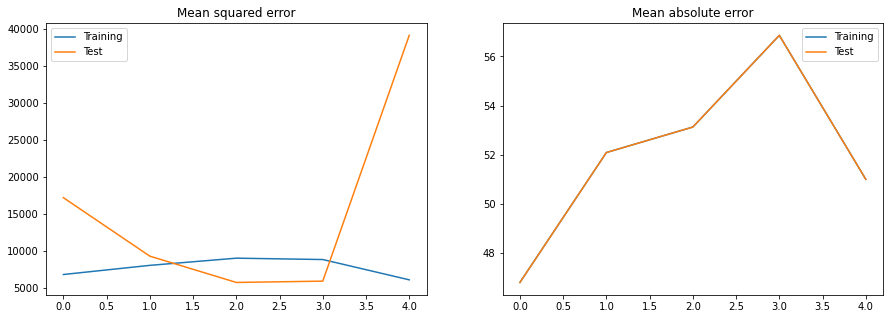

In [23]:
def visualize_history_dict(history_tmp):
    f,axes = plt.subplots(1,2,figsize=(15,5))
    history_tmp.loc[:,'mse_train'].plot(ax = axes[0])
    history_tmp.loc[:,'mse_test'].plot(ax = axes[0])
    axes[0].set_title('Mean squared error')
    axes[0].legend(['Training','Test'])
    
    history_tmp.loc[:,'mae_train'].plot(ax = axes[1])
    history_tmp.loc[:,'mae_test'].plot(ax = axes[1])
    ax = axes[1].set_title('Mean absolute error')
    ax = axes[1].legend(['Training','Test'])


    # history_tmp.loc[:,'corr_train'].plot(ax = axes[2])
    # history_tmp.loc[:,'corr_test'].plot(ax = axes[2])
    # ax = axes[2].set_title('Correlation')
    # ax = axes[2].legend(['Training','Test'])
    plt.show()
        
visualize_history_dict(df_history_linreg)


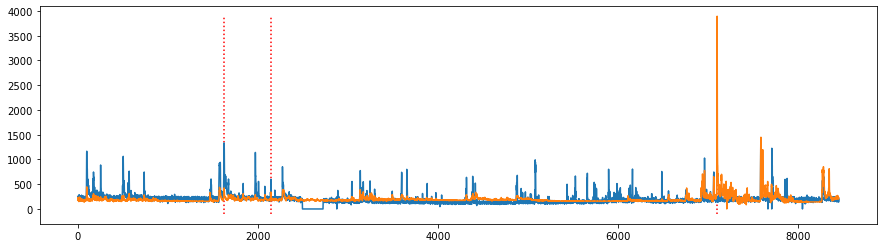

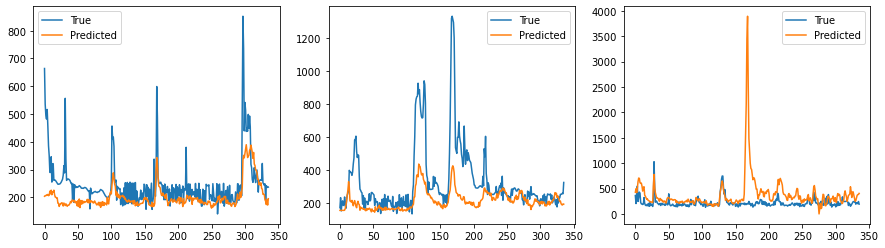

In [24]:
visualize_perforamnce_and_events(y_test_preds_linreg)

In [25]:
def extract_best_performances(dict_obj):
    return pd.DataFrame(dict_obj).min(axis=1).loc[['mse_train','mse_test','mae_train','mae_test']].rename(lambda x : 'best_' + x).to_dict()

In [26]:
lag_values = np.arange(2,168*2,10)
history_list_linreg_lag = []
for lag in lag_values:
    
    history_dict_linreg, models_linreg, y_test_preds_linreg = evaluate_model(LinearRegression(), params = -1, lag = lag)

    history_list_linreg_lag.append(history_dict_linreg)
    
    
df_history_linreg_lag = pd.DataFrame([pd.DataFrame(i).T.mean(axis=0) for i in history_list_linreg_lag])
df_history_linreg_lag.index = lag_values


In [27]:
wandb.init(project='model_comparison_radarsubset_with_periodic_data',
           config={
               'model':'LinearRegression',
           })

test_dict = {i:pd.DataFrame(value).T.mean(axis=0).to_dict() for i,value in zip(lag_values,history_list_linreg_lag)}


for test in test_dict:
    test_dict[test]['lag'] = test
    wandb.log(test_dict[test])
    
best_results_linreg = extract_best_performances(test_dict)
wandb.log(best_results_linreg)

In [28]:
best_results_linreg

{'best_mse_train': 7966.931719973349,
 'best_mse_test': 10405.670268947248,
 'best_mae_train': 54.097102671726795,
 'best_mae_test': 54.097102671726795}

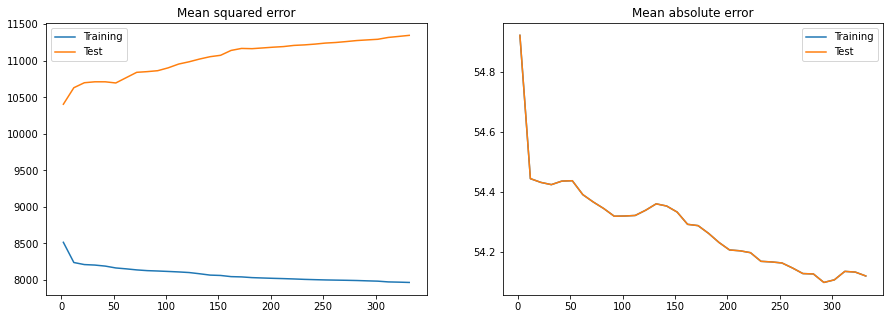

best lag for 2 variables: 2


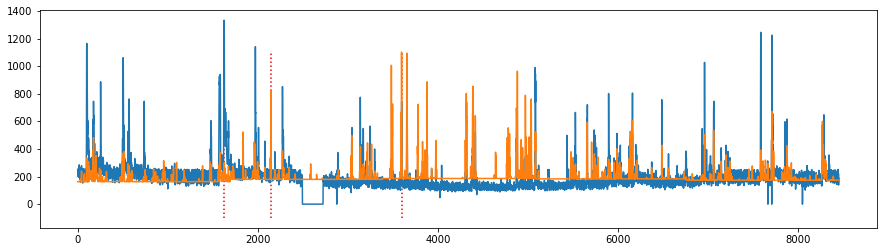

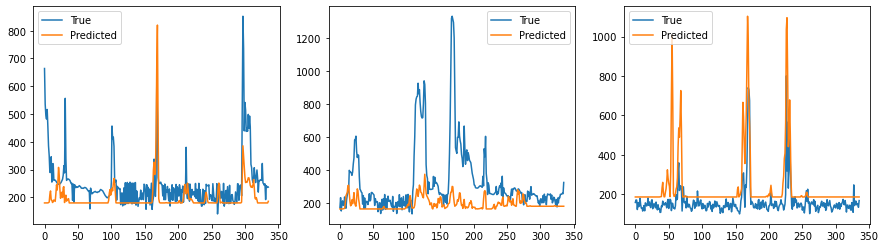

In [29]:
visualize_history_dict(df_history_linreg_lag)
best_lag = df_history_linreg_lag.mse_test.idxmin()
print('best lag for 2 variables:',best_lag)
history_dict_linreg_lag, models_linreg_lag, y_test_preds_linreg_lag = evaluate_model(LinearRegression(), params = -1, lag = best_lag)
visualize_perforamnce_and_events(y_test_preds_linreg_lag)

In [30]:
# kernel = DotProduct() + WhiteKernel() + RationalQuadratic()

# validation_ratio = 0.5
# lag = 168*2
# # n_vars = 1
# # X = input_sequences[:,-lag:,-1].reshape((-1,lag*n_vars))
# # n_vars = 4
# # X = input_sequences[:,-lag:].reshape((-1,lag*n_vars))
# n_vars = 2
# X = input_sequences[:,-lag:,[0,-1]]#.reshape((-1,lag*n_vars))
# X = np.transpose(X,(0,2,1)).reshape(-1,2*lag)

# # time_of_day = np.arange(0,len(output_sequences))%24
# # X = np.c_[X,time_of_day]

# y = output_sequences


# n_train = int(len(X)*(1-validation_ratio))
# X_train = X[:n_train]
# y_train = y[:n_train]
# X_test = X[n_train:]
# y_test = y[n_train:]


# n_subset = 1000 # 58/52 og GEL with 1000 and time of day
# indexes = np.random.choice(len(X_train),n_subset)

# # gpr = GaussianProcessRegressor(kernel=kernel,
# #                                random_state=0,
# #                               #  alpha= 20,
# #                                ).fit(X_train[indexes],y_train[indexes])

# # gpr = SVR('rbf', gamma  = 0.001).fit(X_train[indexes],y_train[indexes])

# gpr = Ridge(0).fit(X_train,y_train)
# # gpr = ARDRegression().fit(X_train[indexes],y_train[indexes])

# # Y_pred = gpr.predict(X, return_std=False)
# Y_pred = gpr.predict(X)
# print(np.mean(np.abs(Y_pred[:n_train] - y[:n_train])))
# print(np.mean(np.abs(Y_pred[n_train:] - y[n_train:])))

# Linear regression with temperature

In [31]:
history_list_linreg_lag_variables = []
for lag in lag_values:
    history_dict_linreg, models_linreg, y_test_preds_linreg = evaluate_model(LinearRegression(), params = [0,-1], lag = lag)
    history_list_linreg_lag_variables.append(history_dict_linreg)
df_history_linreg_lag_variables = pd.DataFrame([pd.DataFrame(i).T.mean(axis=0) for i in history_list_linreg_lag_variables])
df_history_linreg_lag_variables.index = lag_values


In [32]:
wandb.init(project='model_comparison_radarsubset',
           config={
               'model':'LinearRegression with temperature',
           })
test_dict = {i:pd.DataFrame(value).T.mean(axis=0).to_dict() for i,value in zip(lag_values,history_list_linreg_lag_variables)}

for test in test_dict:
    test_dict[test]['lag'] = test
    wandb.log(test_dict[test])
    
best_results_linreg_temp = extract_best_performances(test_dict)
wandb.log(best_results_linreg_temp)

In [33]:
best_results_linreg_temp

{'best_mse_train': 5688.382103154652,
 'best_mse_test': 8092.974840964128,
 'best_mae_train': 44.62394831761753,
 'best_mae_test': 44.62394831761753}

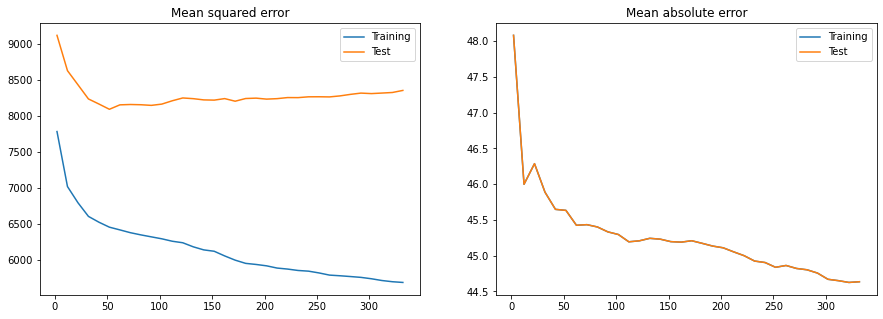

best lag for 2 variables: 52


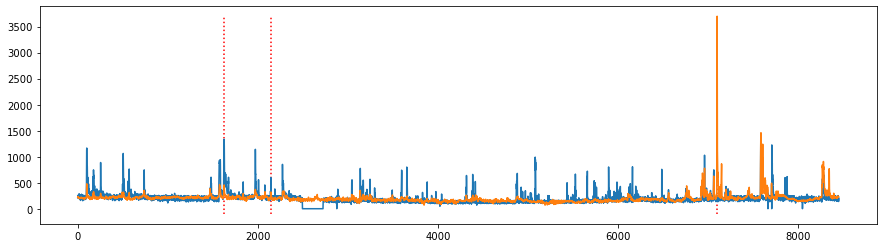

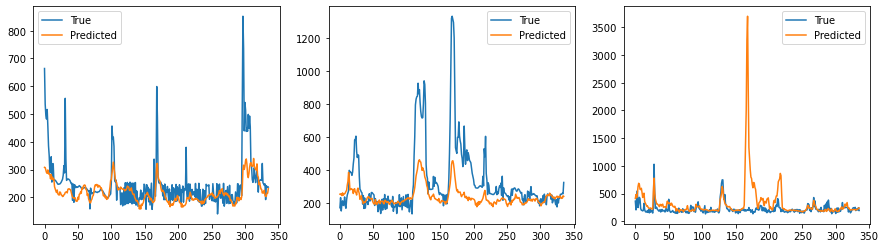

In [34]:
visualize_history_dict(df_history_linreg_lag_variables)
best_lag_variables = df_history_linreg_lag_variables.mse_test.idxmin()
print('best lag for 2 variables:',best_lag_variables)
_, _, y_test_preds_linreg_lag_variables = evaluate_model(LinearRegression(), params = [0,3], lag = best_lag_variables)
visualize_perforamnce_and_events(y_test_preds_linreg_lag_variables)

# Linear regression with more environmental variables

In [38]:
lag_values = np.arange(2,168*2,10)
history_list_linreg_all_vars = []
for lag in lag_values:
    history_dict_linreg, models_linreg, y_test_preds_linreg = evaluate_model(LinearRegression(),params = [0,1,2,3],lag = lag)
    history_list_linreg_all_vars.append(history_dict_linreg)
    
df_history_list_linreg_all_vars = pd.DataFrame([pd.DataFrame(i).T.mean(axis=0) for i in history_list_linreg_all_vars])
df_history_list_linreg_all_vars.index = lag_values


In [39]:
wandb.init(project='model_comparison_radarsubset',
           config={
               'model':'LinearRegression with all variables',
           })
test_dict = {i:pd.DataFrame(value).T.mean(axis=0).to_dict() for i,value in zip(lag_values,history_list_linreg_all_vars)}

for test in test_dict:
    test_dict[test]['lag'] = test
    wandb.log(test_dict[test])
    
best_results_linreg_all = extract_best_performances(test_dict)
wandb.log(best_results_linreg_all)

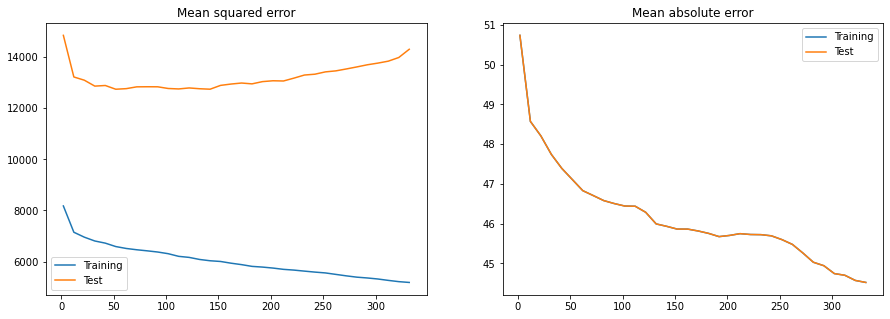

best lag for 2 variables: 52


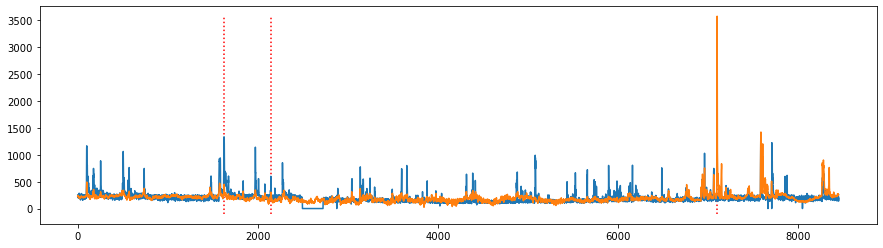

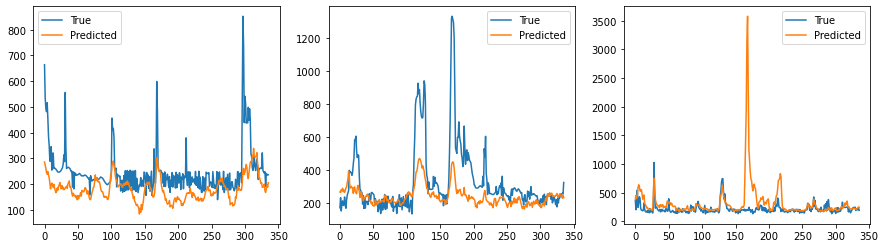

In [40]:
visualize_history_dict(df_history_list_linreg_all_vars)
best_lag_all_vars = df_history_list_linreg_all_vars.mse_test.idxmin()
print('best lag for 2 variables:',best_lag_variables)
_, _, y_test_preds_linreg_lag_all_vars = evaluate_model(LinearRegression(), params = [0,1,2,3], lag = best_lag_all_vars)
visualize_perforamnce_and_events(y_test_preds_linreg_lag_all_vars)

# linear regression with radar data

In [24]:
gain,offset = (0.5, -32.0)
def to_rainfall(radar_data, b = 1.6):
    return wrl.zr.z_to_r(wrl.trafo.idecibel(offset + gain * radar_data), a=200, b=b)



lag = 168*2
input_sequences_radar,output_sequences_radar =\
    get_x_y_with_lag(lag,
                     input_data = df_map,
                     output_data = df_target.loc[:,'RVK-GEL'].resample('1h').sum(),
                     dt_start = df_map.index.min(),
                     dt_end = datetime.datetime(2020,12,31,23,59,59))

In [35]:
# input_sequences_radar.shape


In [36]:
for b in np.linspace(1,2.5,10):
    correlations = to_rainfall(radar_data=input_sequences_radar,b = b).apply(lambda x : x.corr(X.iloc[:,3]))
# plt.imshow(correlations.values.reshape(H,W))
    plt.plot(sorted(correlations),label='b')
plt.legend()
plt.show()

In [64]:
corrs = []
lag_values = range(-168,168)

for i in lag_values:
    shifted = np.roll(input_sequences[:,-1,2055+4].ravel(),i)
    pred_seq = output_sequences.ravel()
    pred_seq = input_sequences[:,-1,3].ravel()
    corr = np.corrcoef(shifted,pred_seq)[0,1]
    corrs.append(corr)

In [65]:
lag_values[np.argmax(corrs)]

0

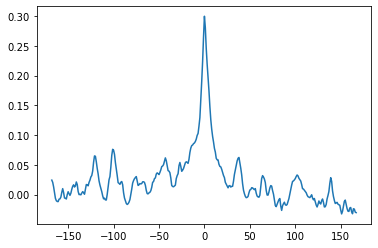

In [66]:
plt.plot(lag_values,corrs)

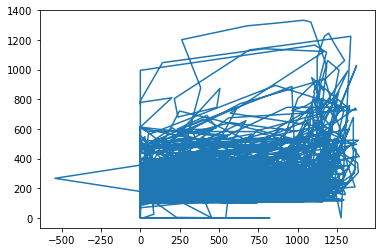

In [50]:
plt.plot(input_sequences[:,-1,2055+4],output_sequences)

In [47]:
input_sequences.shape

(8449, 336, 2404)

In [59]:
for pixel in radar_subset:
    params_radar = [pixel]
    history_list_linreg_radar= []
    for lag in lag_values:
        history_dict_linreg, models_linreg, y_test_preds_linreg = evaluate_model(LinearRegression(),params = params_radar ,lag = lag)
        history_list_linreg_radar.append(history_dict_linreg)
        
    df_history_list_linreg_radar = pd.DataFrame([pd.DataFrame(i).T.mean(axis=0) for i in history_list_linreg_radar])
    df_history_list_linreg_radar.index = lag_values
    print(pixel,df_history_list_linreg_radar.min()['mse_test'])

0 10038.27940574697
1 11616.206422238454
2 10419.365423272971
3 15221.435893086895
4 10032.939566277382
5 9687.538229619979
6 9771.761724223981
7 9994.602558020273
8 10027.130634635188
9 10092.205077409124
10 10156.565070215218
11 10174.779265611443
12 10068.468572179849
13 9930.24692367309
14 9993.228811644984
15 10142.75636351968
16 10176.953240943592
17 9918.152857489458
18 9996.819448419497
19 10169.616439114556
20 10134.576711096855
21 9933.352625096826
22 10066.393157954793
23 9750.703334719263
24 9862.601341568323
25 10132.31980526875
26 10081.731948040177
27 10083.998280994796
28 10218.037145584447
29 10161.398394942194
30 10131.437663311675
31 10104.819481288261
32 10020.757867257114
33 10045.628983565652
34 9926.744157601619
35 10076.041184951338
36 10081.241569105874
37 10207.463686732857
38 10124.33360171504
39 10266.390148178336
40 9842.155880070944
41 9802.637533422818
42 9888.725435842805
43 10084.131851454778
44 10103.413597351648
45 10245.16734419399
46 10283.948047531

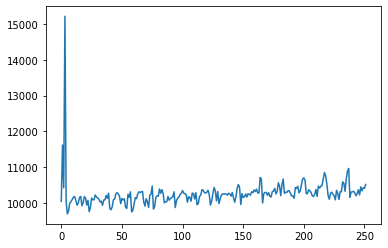

In [62]:
test_list = [(0,10038),(1,11616),(2,10419),(3,15221),(4,10032),(5,9687),(6,9771),(7,9994),(8,10027),(9,10092),(10,10156),
             (11,10174),(12,10068),(13,9930),(14,9993),(15,10142),(16,10176),(17,9918),(18,9996),(19,10169),(20,10134),
             (21,9933),(22,10066),(23,9750),(24,9862),(25,10132),(26,10081),(27,10083),(28,10218),(29,10161),(30,10131),
             (31,10104),(32,10020),(33,10045),(34,9926),(35,10076),(36,10081),(37,10207),(38,10124),(39,10266),(40,9842),
             (41,9802),(42,9888),(43,10084),(44,10103),(45,10245),(46,10283),(47,10246),(48,10183),(49,9974),(50,10119),
             (51,10077),(52,10109),(53,9878),(54,9841),(55,10240),(56,10149),(57,10305),(58,9744),(59,9794),(60,9951),
             (61,10144),(62,10115),(63,10244),(64,10306),(65,10285),(66,10307),(67,10313),(68,10022),(69,9905),(70,10114),
             (71,10028),(72,9872),(73,10209),(74,10237),(75,10467),(76,9824),(77,9895),(78,10152),(79,10196),(80,10183),
             (81,10385),(82,10264),(83,10366),(84,10258),(85,9999),(86,10030),(87,10028),(88,10174),(89,10071),(90,10119),
             (91,10138),(92,10175),(93,10306),(94,9865),(95,10057),(96,10130),(97,10154),(98,10232),(99,10266),(100,10343),
             (101,10266),(102,10257),(103,10223),(104,10015),(105,10168),(106,10150),(107,10045),(108,10269),(109,10258),(110,10106),
             (111,10282),(112,9945),(113,9980),(114,10175),(115,10214),(116,10366),(117,10350),(118,10283),(119,10269),(120,10293),
             (121,10349),(122,10233),(123,9935),(124,10048),(125,10249),(126,10428),(127,10337),(128,10051),(129,10313),(130,9978),
             (131,10092),(132,10216),(133,10249),(134,10236),(135,10254),(136,10241),(137,10212),(138,10267),(139,10244),(140,10186),
             (141,10286),(142,10142),(143,10015),(144,10154),(145,10395),(146,10510),(147,10439),(148,9950),(149,10254),(150,10149),
             (151,10162),(152,10246),(153,10160),(154,10253),(155,10231),(156,10214),(157,10308),(158,10280),(159,10359),(160,10312),
             (161,10380),(162,10273),(163,10275),(164,10707),(165,10662),(166,9993),(167,10255),(168,10291),(169,10286),(170,10211),
             (171,10284),(172,10180),(173,10161),(174,10309),(175,10326),(176,10403),(177,10247),(178,10309),(179,10558),(180,10464),
             (181,10197),(182,10508),(183,10664),(184,10264),(185,10297),(186,10288),(187,10339),(188,10332),(189,10263),(190,10189),
             (191,10191),(192,10126),(193,10422),(194,10404),(195,10464),(196,10275),(197,10326),(198,10499),(199,10665),(200,10695),
             (201,10628),(202,10259),(203,10252),(204,10364),(205,10334),(206,10287),(207,10192),(208,10177),(209,10237),(210,10371),
             (211,10176),(212,10466),(213,10412),(214,10461),(215,10477),(216,10665),(217,10848),(218,10748),(219,10528),(220,10209),
             (221,10097),(222,10262),(223,10296),(224,10240),(225,10197),(226,10081),(227,10349),(228,10257),(229,10090),(230,10312),
             (231,10307),(232,10586),(233,10546),(234,10320),(235,10667),(236,10884),(237,10960),(238,10152),(239,10298),(240,10304),
             (241,10320),(242,10280),(243,10195),(244,10255),(245,10363),(246,10219),(247,10444),(248,10332),(249,10421),(250,10405),
             (251,10510)]
test_array = np.array(test_list)
plt.plot(test_array[:,0],test_array[:,1])

In [71]:
np.argsort(test_array[:,1])

array([  5,  58,  23,   6,  59,  41,  76,  54,  40,  24,  94,  72,  53,
        42,  77,  69,  17,  34,  13,  21, 123, 112, 148,  60,  49, 130,
       113, 166,  14,   7,  18,  85, 104, 143,  32,  68,   8,  87,  71,
        86,   4,   0,  33, 107, 124, 128,  95,  22,  12,  89,  35,  51,
       226,  26,  36,  27,  43, 229, 131,   9, 221,  44,  31, 110,  52,
        70,  62,  90,  50,  38, 192,  96,  30,  25,  20,  91,  15, 142,
        61,  56, 150, 106, 238,  78, 144,  97,  10, 153,  29, 173, 151,
       105,  19,  88,  11,  92, 114, 211,  16, 208, 172,  80,  48, 140,
       190, 191, 207, 243,  79, 225, 181,  37,  73, 220, 170, 137, 115,
       156, 132,  28, 246, 103, 155,  98, 122, 134, 209,  74,  55, 224,
       136,  63, 139,  45,  47, 152, 177, 125, 133, 203, 154, 149, 135,
       167, 244, 228, 102,  84, 109, 202, 222, 189, 184,  82, 101,  39,
        99, 138, 119, 108, 162, 163, 196, 158, 242, 111,  46, 118, 171,
        65, 141, 169, 206, 186, 168, 120, 223, 185, 239, 240,  5

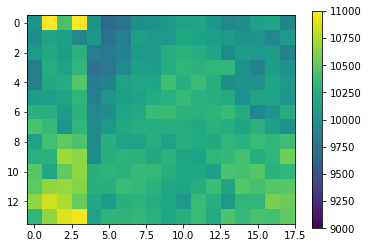

In [68]:
plt.imshow(test_array[:,1].reshape((H,W)),vmin = 9000,vmax = 11000)
plt.colorbar()

array([ 67, 117, 226,  25,  31])

In [89]:
lag_values = [1,2,3,6,12,24,24*3,168,168*2]


params_radar = np.random.choice(radar_subset,20).astype(int)
history_list_linreg_radar= []
for lag in lag_values:
    history_dict_linreg, models_linreg, y_test_preds_linreg = evaluate_model(LinearRegression(),params = params_radar ,lag = lag)
    history_list_linreg_radar.append(history_dict_linreg)
    
df_history_list_linreg_radar = pd.DataFrame([pd.DataFrame(i).T.mean(axis=0) for i in history_list_linreg_radar])
df_history_list_linreg_radar.index = lag_values


visualize_history_dict(df_history_list_linreg_radar)
best_lag_all_vars = df_history_list_linreg_radar.mse_test.idxmin()
_, _, y_test_preds_linreg_lag_all_vars = evaluate_model(LinearRegression(), params = params_radar , lag = best_lag_all_vars)
visualize_perforamnce_and_events(y_test_preds_linreg_lag_all_vars)

KeyboardInterrupt: 

# Using LSTMs for temporal relationships

LSTM training:
- We must train the model 10 different times, each time with different initial parameteres, to get a good estimate of the average performance
 

In [ ]:
project = 'LSTM_training'
config = {
    'Dense_1': 2,
    'activation_1': 'relu',
    'LSTM' : 100,
    'Dense_2': 2,
    'activation_2': 'relu',
    'optimizer': 'Adam',
    'loss': 'Mean Squared Error',
    'metric': 'MAE',
    'epochs': 50,
    'batch_size': 32,
    'lr' : 0.005,
    'lr_decay' : 0.9,
    'lag' : 168,
    'early_stopper_patience' : 3,
    'fold':0,
}
wandb.init(project=project,config=config)

def refresh_wandb(fold = False):
    if fold:
        config['fold'] += 1
    else:
        config['fold'] = 0
    wandb.init(project = project,
               config = config)



early_stopper = tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0, patience=wandb.config['early_stopper_patience'], verbose=0, mode='min', baseline=None, restore_best_weights=True,)
logging_callback = wandb.keras.WandbCallback(log_evaluation=False)
learning_rates = np.logspace(0,-5,6*4-3)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch,lr : learning_rates[int(epoch/wandb.config['epochs'] * len(learning_rates))], verbose=1)

def construct_simple_encoder_decoder_lstm():

    model = Sequential()
    model.add(Input((wandb.config['lag'],1)))
    model.add(Dense(wandb.config['Dense_1'],
                    activation=wandb.config['activation_1']
                    ))
    model.add(LSTM(wandb.config['LSTM'],
                   return_sequences=True))
    model.add(Dense(wandb.config['Dense_2'],
                    activation=wandb.config['activation_2']))
    model.add(Flatten())
    model.add(Dense(1))
    
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=wandb.config['lr']),
                  loss = tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE,
                           tfp.stats.correlation])
    refresh_wandb(True)
    return model

# tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True)

refresh_wandb()
with tf.device('/cpu:0'):
    history_dict_lstm, models_lstm, y_test_preds_lstm = evaluate_model(None,
                                                                        params = [-1],
                                                                        lag = wandb.config['lag'],
                                                                        squeeze = False,
                                                                        
                                                                        model_constructor = construct_simple_encoder_decoder_lstm,
                                                                        specify_validation_data = True,
                                                                        folds = 5,
                                                                        # Kwargs
                                                                        batch_size = wandb.config['batch_size'],
                                                                        epochs = wandb.config['epochs'],
                                                                        shuffle=True,
                                                                        callbacks = [
                                                                            lr_scheduler,
                                                                            early_stopper,
                                                                            logging_callback
                                                                                    ],
                                                                        verbose = 1
                                                                        )

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 1.0.
212/212 [==============================] - 14s 56ms/step - loss: 301551.7188 - mean_absolute_error: 124.2890 - mean_squared_error: 301551.7188 - correlation: nan - val_loss: 31198.6523 - val_mean_absolute_error: 102.7441 - val_mean_squared_error: 31198.6523 - val_correlation: nan
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 1.0.
212/212 [==============================] - 11s 54ms/step - loss: nan - mean_absolute_error: nan - mean_squared_error: nan - correlation: nan - val_loss: nan - val_mean_absolute_error: nan - val_mean_squared_error: nan - val_correlation: nan
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 1.0.
212/212 [==============================] - 11s 53ms/step - loss: nan - mean_absolute_error: nan - mean_squared_error: nan - correlation: nan - val_loss: nan - val_mean_absolute_error: nan - val_mean_squared_error: nan - val_correlation: nan
Epoch 

KeyboardInterrupt: 

In [ ]:
wandb.init(project='model_comparison_radarsubset',
           config={
               'model':'LSTM with a single variable',
           })
test_dict = {i:pd.DataFrame(value).T.mean(axis=0).to_dict() for i,value in zip(lag_values,history_list_linreg_all_vars)}

for test in history_dict_lstm:
    history_dict_lstm[test]['fold'] = test
    
    print(history_dict_lstm[test])
    # wandb.log(history_dict_lstm[test])
    
best_results_lstm = extract_best_performances(history_dict_lstm)
wandb.log(best_results_lstm)
best_results_lstm

{'mse_train': 6687.0415, 'mse_test': 7186.2026, 'mae_train': 52.511868, 'mae_test': 52.511868, 'fold': 0}
{'mse_train': 6195.983, 'mse_test': 8996.416, 'mae_train': 51.385056, 'mae_test': 51.385056, 'fold': 1}
{'mse_train': 37010.973, 'mse_test': 35478.89, 'mae_train': 155.75644, 'mae_test': 155.75644, 'fold': 2}
{'mse_train': 7342.318, 'mse_test': 5806.451, 'mae_train': 53.22102, 'mae_test': 53.22102, 'fold': 3}
{'mse_train': 6664.303, 'mse_test': 6701.386, 'mae_train': 52.191032, 'mae_test': 52.191032, 'fold': 4}


{'best_mse_train': 6195.98291015625,
 'best_mse_test': 5806.451171875,
 'best_mae_train': 51.38505554199219,
 'best_mae_test': 51.38505554199219}

# Using LSTMs with in addition to more weather data for potential hydrological modelling

In [ ]:
project = 'LSTM_training'
config = {
    'Dense_1': 2,
    'activation_1': 'relu',
    'LSTM' : 10,
    'Dense_2': 2,
    'activation_2': 'relu',
    'optimizer': 'Adam',
    'loss': 'Mean Squared Error',
    'metric': 'MAE',
    'epochs': 50,
    'batch_size': 32,
    'lr' : 0.001,
    'lr_decay' : 0.9,
    'lag' : 168,
    'early_stopper_patience' : 3,
    'fold':0,
}
wandb.init(project=project,config=config)

def refresh_wandb(fold = False):
    if fold:
        config['fold'] += 1
    else:
        config['fold'] = 0
    wandb.init(project = project,
               config = config)



early_stopper = tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0, patience=wandb.config['early_stopper_patience'], verbose=0, mode='min', baseline=None, restore_best_weights=True,)
logging_callback = wandb.keras.WandbCallback(log_evaluation=False)
learning_rates = np.logspace(0,-5,6*4-3)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch,lr : learning_rates[int(epoch/wandb.config['epochs'] * len(learning_rates))], verbose=1)


def construct_simple_encoder_decoder_lstm_with_temperature():
    
    model = Sequential()
    model.add(Input((wandb.config['lag'],2)))
    model.add(Dense(wandb.config['Dense_1'],
                    activation=wandb.config['activation_1']
                    ))
    model.add(LSTM(wandb.config['LSTM'],
                   return_sequences=True))
    model.add(Dense(wandb.config['Dense_2'],
                    activation=wandb.config['activation_2']))
    model.add(Flatten())
    model.add(Dense(1))
    
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=wandb.config['lr']),
                  loss = tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE,
                           tfp.stats.correlation])
    refresh_wandb(True)
    return model

refresh_wandb()
with tf.device('/gpu:0'):
    history_dict_lstm_temp, models_lstm_temp, y_test_preds_lstm_temp = evaluate_model(None,
                                                                        params = [0,3],
                                                                        lag = wandb.config['lag'],
                                                                        squeeze = False,
                                                                        
                                                                        model_constructor = construct_simple_encoder_decoder_lstm_with_temperature,
                                                                        specify_validation_data = True,
                                                                        folds = 5,
                                                                        # Kwargs
                                                                        batch_size = wandb.config['batch_size'],
                                                                        epochs = wandb.config['epochs'],
                                                                        shuffle=True,
                                                                        callbacks = [
                                                                            # lr_scheduler,
                                                                            early_stopper,
                                                                            logging_callback
                                                                                    ],
                                                                        verbose = 1
                                                                        )

Epoch 1/50
907/907 [==============================] - 16s 15ms/step - loss: 15068.4082 - mean_absolute_error: 71.1487 - mean_squared_error: 15068.4082 - correlation: 0.3363 - val_loss: 11078.3965 - val_mean_absolute_error: 57.1059 - val_mean_squared_error: 11078.3965 - val_correlation: nan
Epoch 2/50
907/907 [==============================] - 12s 13ms/step - loss: 10269.0625 - mean_absolute_error: 51.5800 - mean_squared_error: 10269.0625 - correlation: 0.4717 - val_loss: 10714.7949 - val_mean_absolute_error: 52.3962 - val_mean_squared_error: 10714.7949 - val_correlation: nan
Epoch 3/50
907/907 [==============================] - 13s 15ms/step - loss: 9813.5361 - mean_absolute_error: 50.3031 - mean_squared_error: 9813.5361 - correlation: 0.5067 - val_loss: 9686.9238 - val_mean_absolute_error: 51.4776 - val_mean_squared_error: 9686.9238 - val_correlation: 0.1271
Epoch 4/50
907/907 [==============================] - 13s 14ms/step - loss: 9238.4531 - mean_absolute_error: 49.0362 - mean_squa

In [ ]:
wandb.init(project='model_comparison_radarsubset',
           config={
               'model':'LSTM with temperature',
           })
# test_dict = {i:pd.DataFrame(value).T.mean(axis=0).to_dict() for i,value in zip(lag_values,history_list_linreg_all_vars)}

for test in history_dict_lstm_temp:
    history_dict_lstm_temp[test]['fold'] = test
    wandb.log(history_dict_lstm_temp[test])
    
print(history_dict_lstm_temp)
best_results_lstm_temp = extract_best_performances(history_dict_lstm_temp)
wandb.log(best_results_lstm_temp)
best_results_lstm_temp

{0: {'mse_train': 5168.698, 'mse_test': 6131.178, 'mae_train': 41.769363, 'mae_test': 41.769363, 'fold': 0}, 1: {'mse_train': 5072.6543, 'mse_test': 7710.092, 'mae_train': 41.599545, 'mae_test': 41.599545, 'fold': 1}, 2: {'mse_train': 10907.42, 'mse_test': 9676.259, 'mae_train': 53.470585, 'mae_test': 53.470585, 'fold': 2}, 3: {'mse_train': 6007.4917, 'mse_test': 4647.2744, 'mae_train': 46.26594, 'mae_test': 46.26594, 'fold': 3}, 4: {'mse_train': 5815.9473, 'mse_test': 6268.8247, 'mae_train': 44.277084, 'mae_test': 44.277084, 'fold': 4}}


{'best_mse_train': 5072.654296875,
 'best_mse_test': 4647.2744140625,
 'best_mae_train': 41.599544525146484,
 'best_mae_test': 41.599544525146484}

In [ ]:
project = 'LSTM_training'
config = {
    'Dense_1': 2,
    'activation_1': 'relu',
    'LSTM' : 10,
    'Dense_2': 2,
    'activation_2': 'relu',
    'optimizer': 'Adam',
    'loss': 'Mean Squared Error',
    'metric': 'MAE',
    'epochs': 50,
    'batch_size': 32,
    'lr' : 0.001,
    'lr_decay' : 0.9,
    'lag' : 168,
    'early_stopper_patience' : 3,
    'fold':0,
}
wandb.init(project=project,config=config)

def refresh_wandb(fold = False):
    if fold:
        config['fold'] += 1
    else:
        config['fold'] = 0
    wandb.init(project = project,
               config = config)



early_stopper = tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0, patience=wandb.config['early_stopper_patience'], verbose=0, mode='min', baseline=None, restore_best_weights=True,)
logging_callback = wandb.keras.WandbCallback(log_evaluation=False)
learning_rates = np.logspace(0,-5,6*4-3)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch,lr : learning_rates[int(epoch/wandb.config['epochs'] * len(learning_rates))], verbose=1)


def construct_simple_encoder_decoder_lstm_with_all_variables():
    
    model = Sequential()
    model.add(Input((wandb.config['lag'],4)))
    model.add(Dense(wandb.config['Dense_1'],
                    activation=wandb.config['activation_1']
                    ))
    model.add(LSTM(wandb.config['LSTM'],
                   return_sequences=True))
    model.add(Dense(wandb.config['Dense_2'],
                    activation=wandb.config['activation_2']))
    model.add(Flatten())
    model.add(Dense(1))
    
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=wandb.config['lr']),
                  loss = tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE,
                           tfp.stats.correlation])
    refresh_wandb(True)
    return model

refresh_wandb()
with tf.device('/gpu:0'):
    history_dict_lstm_all, models_lstm_all, y_test_preds_lstm_all = evaluate_model(None,
                                                                        params = [0,1,2,3],
                                                                        lag = wandb.config['lag'],
                                                                        squeeze = False,
                                                                        
                                                                        model_constructor = construct_simple_encoder_decoder_lstm_with_all_variables,
                                                                        specify_validation_data = True,
                                                                        folds = 5,
                                                                        # Kwargs
                                                                        batch_size = wandb.config['batch_size'],
                                                                        epochs = wandb.config['epochs'],
                                                                        shuffle=True,
                                                                        callbacks = [
                                                                            # lr_scheduler,
                                                                            early_stopper,
                                                                            logging_callback
                                                                                    ],
                                                                        verbose = 1
                                                                        )

Epoch 1/50
907/907 [==============================] - 18s 18ms/step - loss: 14391.0889 - mean_absolute_error: 69.8021 - mean_squared_error: 14391.0889 - correlation: 0.2740 - val_loss: 11537.3887 - val_mean_absolute_error: 58.6009 - val_mean_squared_error: 11537.3887 - val_correlation: 0.0916
Epoch 2/50
907/907 [==============================] - 16s 17ms/step - loss: 10719.1543 - mean_absolute_error: 54.8652 - mean_squared_error: 10719.1543 - correlation: 0.4200 - val_loss: 11009.0908 - val_mean_absolute_error: 57.9992 - val_mean_squared_error: 11009.0908 - val_correlation: 0.1152
Epoch 3/50
907/907 [==============================] - 15s 17ms/step - loss: 10456.8955 - mean_absolute_error: 53.8206 - mean_squared_error: 10456.8955 - correlation: 0.4465 - val_loss: 10801.0801 - val_mean_absolute_error: 57.1267 - val_mean_squared_error: 10801.0801 - val_correlation: 0.1125
Epoch 4/50
907/907 [==============================] - 14s 15ms/step - loss: 10149.4033 - mean_absolute_error: 52.6456 

In [ ]:
history_dict_lstm_all

{0: {'mse_train': 5472.3237,
  'mse_test': 6514.931,
  'mae_train': 41.153057,
  'mae_test': 41.153057,
  'fold': 0},
 1: {'mse_train': 9804.343,
  'mse_test': 15195.922,
  'mae_train': 55.651962,
  'mae_test': 55.651962,
  'fold': 1},
 2: {'mse_train': 6105.565,
  'mse_test': 6773.964,
  'mae_train': 43.450546,
  'mae_test': 43.450546,
  'fold': 2},
 3: {'mse_train': 5961.153,
  'mse_test': 4720.514,
  'mae_train': 45.39275,
  'mae_test': 45.39275,
  'fold': 3},
 4: {'mse_train': 10931.696,
  'mse_test': 10365.353,
  'mae_train': 56.317318,
  'mae_test': 56.317318,
  'fold': 4}}

In [ ]:
wandb.init(project='model_comparison_radarsubset',
           config={
               'model':'LSTM with all variables',
               'lag':0
           })
# test_dict = {i:pd.DataFrame(value).T.mean(axis=0).to_dict() for i,value in zip(lag_values,history_list_linreg_all_vars)}

for test in history_dict_lstm_all:
    history_dict_lstm_all[test]['lag'] = test
    print(history_dict_lstm_all[test])
    wandb.log(history_dict_lstm_all[test])
    
# print(history_dict_lstm_all)
best_results_lstm_all = extract_best_performances(history_dict_lstm_all)
wandb.log(best_results_lstm_all)
best_results_lstm_all

{'mse_train': 5472.3237, 'mse_test': 6514.931, 'mae_train': 41.153057, 'mae_test': 41.153057, 'fold': 0, 'lag': 0}
{'mse_train': 9804.343, 'mse_test': 15195.922, 'mae_train': 55.651962, 'mae_test': 55.651962, 'fold': 1, 'lag': 1}
{'mse_train': 6105.565, 'mse_test': 6773.964, 'mae_train': 43.450546, 'mae_test': 43.450546, 'fold': 2, 'lag': 2}
{'mse_train': 5961.153, 'mse_test': 4720.514, 'mae_train': 45.39275, 'mae_test': 45.39275, 'fold': 3, 'lag': 3}
{'mse_train': 10931.696, 'mse_test': 10365.353, 'mae_train': 56.317318, 'mae_test': 56.317318, 'fold': 4, 'lag': 4}


{'best_mse_train': 5472.32373046875,
 'best_mse_test': 4720.51416015625,
 'best_mae_train': 41.15305709838867,
 'best_mae_test': 41.15305709838867}

# LSTM with all variables and more complex encoder-decoder structure

In [ ]:
project = 'LSTM_training'
config = {
    'Dense_E1': 2,
    'Dense_E2': 2,
    'activation_E1': 'relu',
    'activation_E2': 'relu',
    'LSTM' : 10,
    'Dense_D1': 2,
    'Dense_D2': 1,
    'activation_D1': 'relu',
    'activation_D2': 'relu',
    'optimizer': 'Adam',
    'loss': 'Mean Squared Error',
    'metric': 'MAE',
    'epochs': 50,
    'batch_size': 16,
    'lr' : 0.01,
    'lag' : 168,
    'early_stopper_patience' : 6,
    'fold':0,
}
wandb.init(project=project,config=config)

def refresh_wandb(fold = False):
    if fold:
        config['fold'] += 1
    else:
        config['fold'] = 0
    wandb.init(project = project,
               config = config)



early_stopper = tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0, patience=wandb.config['early_stopper_patience'], verbose=0, mode='min', baseline=None, restore_best_weights=True,)
logging_callback = wandb.keras.WandbCallback(log_evaluation=False)
learning_rates = np.logspace(-2,-4,6*4-3)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch,lr : learning_rates[int(epoch/wandb.config['epochs'] * len(learning_rates))], verbose=1)


def construct_simple_encoder_decoder_lstm_with_all_variables():
    
    model = Sequential()
    model.add(Input((wandb.config['lag'],4)))
    model.add(Dense(wandb.config['Dense_E1'],activation=wandb.config['activation_E1']))
    model.add(Dense(wandb.config['Dense_E2'],activation=wandb.config['activation_E2']))
    model.add(LSTM(wandb.config['LSTM'],return_sequences=True))
    model.add(Dense(wandb.config['Dense_D1'],activation=wandb.config['activation_D1']))
    model.add(Dense(wandb.config['Dense_D2'],activation=wandb.config['activation_D2']))
    model.add(Flatten())
    model.add(Dense(1,activation='linear'))
    
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=wandb.config['lr']),
                  loss = tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE,
                           tfp.stats.correlation])
    refresh_wandb(True)
    return model


In [ ]:
refresh_wandb()
with tf.device('/gpu:0'):
    history_dict_lstm_all, models_lstm_all, y_test_preds_lstm_all = evaluate_model(None,
                                                                        params = [0,1,2,3],
                                                                        lag = wandb.config['lag'],
                                                                        squeeze = False,
                                                                        
                                                                        model_constructor = construct_simple_encoder_decoder_lstm_with_all_variables,
                                                                        specify_validation_data = True,
                                                                        folds = 5,
                                                                        # Kwargs
                                                                        batch_size = wandb.config['batch_size'],
                                                                        epochs = wandb.config['epochs'],
                                                                        shuffle=True,
                                                                        callbacks = [
                                                                            lr_scheduler,
                                                                            early_stopper,
                                                                            logging_callback
                                                                                    ],
                                                                        verbose = 1
                                                                        )

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
1814/1814 [==============================] - 33s 15ms/step - loss: 11399.3125 - mean_absolute_error: 58.1042 - mean_squared_error: 11399.3125 - correlation: 0.4105 - val_loss: 11195.3125 - val_mean_absolute_error: 57.2678 - val_mean_squared_error: 11195.3125 - val_correlation: 0.0692
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.01.
1814/1814 [==============================] - 26s 14ms/step - loss: 10822.9590 - mean_absolute_error: 54.9230 - mean_squared_error: 10822.9590 - correlation: 0.4702 - val_loss: 10171.2197 - val_mean_absolute_error: 53.6022 - val_mean_squared_error: 10171.2197 - val_correlation: 0.1001
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.01.
1814/1814 [==============================] - 26s 14ms/step - loss: 9405.9570 - mean_absolute_error: 52.3100 - mean_squared_error: 9405.9570 - correlation: 0.5568 - val_loss: 8872.8574 - val_mean_a

KeyboardInterrupt: 

# Seq-to-seq architecture

In [ ]:
project = 'LSTM_training'
config = {
    'name' : 'random_variations',
    'Dense_E1': 2,
    'Dense_E2': 2,
    'activation_E1': 'relu',
    'activation_E2': 'relu',
    'LSTM' : 10,
    'Dense_D1': 2,
    'Dense_D2': 1,
    'activation_D1': 'relu',
    'activation_D2': 'relu',
    'optimizer': 'Adam',
    'loss': 'Mean Squared Error',
    'metric': 'MAE',
    'epochs': 10,
    'batch_size': 16,
    'lr' : 0.01,
    'lag' : 168,
    'early_stopper_patience' : 6,
    'fold':0,
}
wandb.init(project=project,config=config)

def refresh_wandb(fold = False):
    if fold:
        config['fold'] += 1
    else:
        config['fold'] = 0
    wandb.init(project = project,
               config = config)



early_stopper = tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0, patience=wandb.config['early_stopper_patience'], verbose=0, mode='min', baseline=None, restore_best_weights=True,)
logging_callback = wandb.keras.WandbCallback(log_evaluation=False)
learning_rates = np.logspace(-1,-4,6*4-3)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch,lr : learning_rates[int(epoch/wandb.config['epochs'] * len(learning_rates))], verbose=1)


def construct_test_model():
    
    model = Sequential()
    model.add(Input((wandb.config['lag'],4)))
    model.add(Dense(wandb.config['Dense_E1'],activation=wandb.config['activation_E1']))
    model.add(Dense(wandb.config['Dense_E2'],activation=wandb.config['activation_E2']))
    model.add(LSTM(wandb.config['LSTM'],return_sequences=True))
    model.add(Dense(wandb.config['Dense_D1'],activation=wandb.config['activation_D1']))
    # model.add(Dense(wandb.config['Dense_D2'],activation=wandb.config['activation_D2']))
    model.add(Flatten())
    model.add(Dense(1,activation='linear'))
    
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=wandb.config['lr']),
                  loss = tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE,
                           tfp.stats.correlation])
    refresh_wandb(True)
    return model



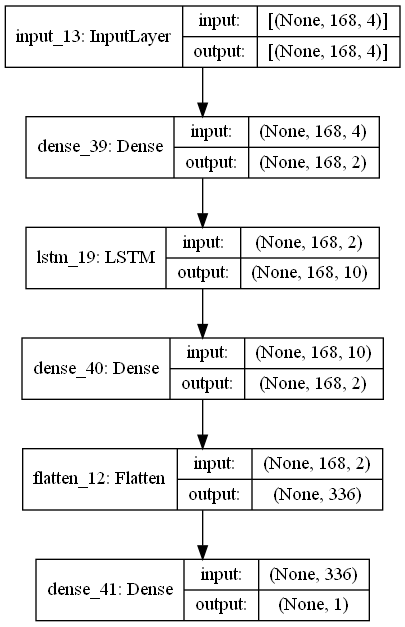

In [ ]:
model = construct_test_model()
tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True)


In [ ]:
refresh_wandb()
with tf.device('/gpu:0'):
    history_dict_lstm_all, models_lstm_all, y_test_preds_lstm_all = evaluate_model(None,
                                                                        params = [0,1,2,3],
                                                                        lag = wandb.config['lag'],
                                                                        squeeze = False,
                                                                        
                                                                        model_constructor = construct_test_model,
                                                                        specify_validation_data = True,
                                                                        folds = 5,
                                                                        # Kwargs
                                                                        batch_size = wandb.config['batch_size'],
                                                                        epochs = wandb.config['epochs'],
                                                                        shuffle=True,
                                                                        callbacks = [
                                                                            lr_scheduler,
                                                                            early_stopper,
                                                                            logging_callback
                                                                                    ],
                                                                        verbose = 1
                                                                        )


Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
1814/1814 [==============================] - 30s 15ms/step - loss: 11786.9941 - mean_absolute_error: 61.2352 - mean_squared_error: 11786.9941 - correlation: 0.3965 - val_loss: 12234.5547 - val_mean_absolute_error: 60.5387 - val_mean_squared_error: 12234.5547 - val_correlation: nan
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.05011872336272722.
1814/1814 [==============================] - 25s 14ms/step - loss: 11036.2803 - mean_absolute_error: 57.4575 - mean_squared_error: 11036.2803 - correlation: 0.4422 - val_loss: 11355.4639 - val_mean_absolute_error: 66.4569 - val_mean_squared_error: 11355.4639 - val_correlation: 0.1249
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.025118864315095794.
1814/1814 [==============================] - 24s 13ms/step - loss: 9862.0225 - mean_absolute_error: 55.2736 - mean_squared_error: 9862.0225 - correlation: 0.4805 - val_l

KeyboardInterrupt: 

# Seq-to-seq with attention

In [ ]:
project = 'LSTM_training'
config = {
    'name' : 'random_variations',
    'Dense_E1': 2,
    'Dense_E2': 2,
    'activation_E1': 'relu',
    'activation_E2': 'relu',
    'LSTM' : 10,
    'Dense_D1': 2,
    'Dense_D2': 1,
    'activation_D1': 'relu',
    'activation_D2': 'relu',
    'optimizer': 'Adam',
    'loss': 'Mean Squared Error',
    'metric': 'MAE',
    'epochs': 10,
    'batch_size': 16,
    'lr' : 0.01,
    'lag' : 168,
    'early_stopper_patience' : 6,
    'fold':0,
}
wandb.init(project=project,config=config)

def refresh_wandb(fold = False):
    if fold:
        config['fold'] += 1
    else:
        config['fold'] = 0
    wandb.init(project = project,
               config = config)



early_stopper = tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0, patience=wandb.config['early_stopper_patience'], verbose=0, mode='min', baseline=None, restore_best_weights=True,)
logging_callback = wandb.keras.WandbCallback(log_evaluation=False)
learning_rates = np.logspace(-1,-4,6*4-3)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch,lr : learning_rates[int(epoch/wandb.config['epochs'] * len(learning_rates))], verbose=1)


def construct_attention_model():
    model = Sequential()
    model.add(Input((wandb.config['lag'],4)))
    model.add(Dense(wandb.config['Dense_E1'],activation=wandb.config['activation_E1']))
    model.add(Dense(wandb.config['Dense_E2'],activation=wandb.config['activation_E2']))
    model.add(LSTM(wandb.config['LSTM'],return_sequences=True))
    
    
    
    inputs = Input(shape=(wandb.config['lag'], 4))
    lstm_out = LSTM(wandb.config['LSTM'], return_sequences=True)(inputs)

    attention = Dense(1, activation='elu')(lstm_out)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(hidden)(attention)
    attention = Permute([2,1])(attention)

    combined = Multiply()([lstm_out, attention])
    combined_mul = Flatten()(combined)
    decode = RepeatVector(output_length)(combined_mul)
    decode = LSTM(hidden, return_sequences=True)(decode)
    decode = TimeDistributed(Dense(1))(decode)
    decode = Activation('linear')(decode)

    model = Model(inputs=[inputs], outputs=decode)

    # model = Sequential()
    # model.add(Input((wandb.config['lag'],4)))
    # model.add(Dense(wandb.config['Dense_E1'],activation=wandb.config['activation_E1']))
    # model.add(Dense(wandb.config['Dense_E2'],activation=wandb.config['activation_E2']))
    # model.add(LSTM(wandb.config['LSTM'],return_sequences=True))
    # model.add(Dense(wandb.config['Dense_D1'],activation=wandb.config['activation_D1']))
    # # model.add(Dense(wandb.config['Dense_D2'],activation=wandb.config['activation_D2']))
    # model.add(Flatten())
    # model.add(Dense(1,activation='linear'))
    
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=wandb.config['lr']),
                  loss = tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE,
                           tfp.stats.correlation])
    refresh_wandb(True)
    return model



In [ ]:
from tensorflow.keras import Model

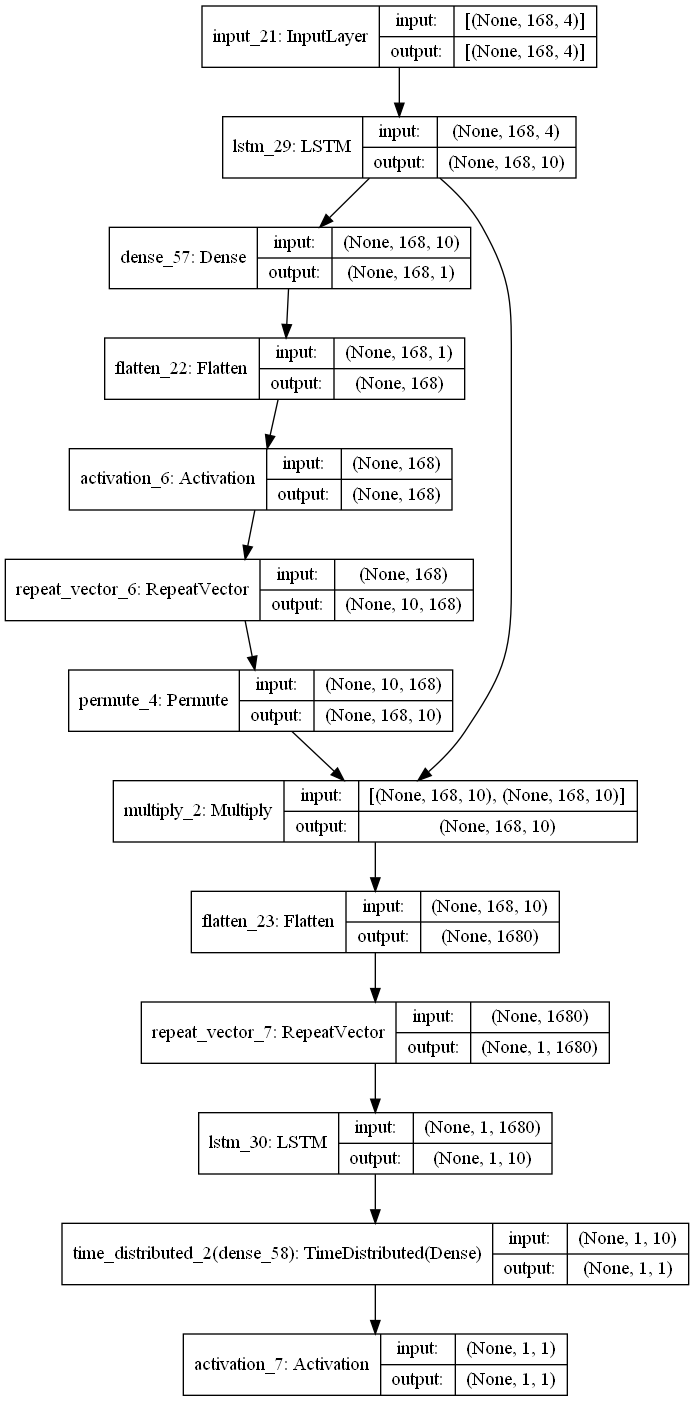

In [ ]:
model = construct_attention_model()
tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True)

In [ ]:
refresh_wandb()
with tf.device('/gpu:0'):
    history_dict_lstm_all, models_lstm_all, y_test_preds_lstm_all = evaluate_model(None,
                                                                        params = [0,1,2,3],
                                                                        lag = wandb.config['lag'],
                                                                        squeeze = False,
                                                                        
                                                                        model_constructor = construct_attention_model,
                                                                        specify_validation_data = True,
                                                                        folds = 5,
                                                                        # Kwargs
                                                                        batch_size = wandb.config['batch_size'],
                                                                        epochs = wandb.config['epochs'],
                                                                        shuffle=True,
                                                                        callbacks = [
                                                                            lr_scheduler,
                                                                            early_stopper,
                                                                            logging_callback
                                                                                    ],
                                                                        verbose = 1
                                                                        )


Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
1814/1814 [==============================] - 33s 17ms/step - loss: 14162.3916 - mean_absolute_error: 69.8887 - mean_squared_error: 14162.3916 - correlation: nan - val_loss: 13834.1211 - val_mean_absolute_error: 73.7180 - val_mean_squared_error: 13834.1211 - val_correlation: nan
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.05011872336272722.
   9/1814 [..............................] - ETA: 26s - loss: 10015.6719 - mean_absolute_error: 65.7462 - mean_squared_error: 10015.6719 - correlation: 0.3409

C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


1814/1814 [==============================] - 27s 15ms/step - loss: 12233.1416 - mean_absolute_error: 63.2429 - mean_squared_error: 12233.1416 - correlation: 0.2733 - val_loss: 13875.7715 - val_mean_absolute_error: 73.5569 - val_mean_squared_error: 13875.7715 - val_correlation: nan
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.025118864315095794.
1814/1814 [==============================] - 28s 15ms/step - loss: 12230.2090 - mean_absolute_error: 63.1895 - mean_squared_error: 12230.2090 - correlation: 0.2688 - val_loss: 13853.1367 - val_mean_absolute_error: 73.6337 - val_mean_squared_error: 13853.1367 - val_correlation: nan
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.012589254117941675.
1814/1814 [==============================] - 29s 16ms/step - loss: 12227.1016 - mean_absolute_error: 63.1737 - mean_squared_error: 12227.1016 - correlation: 0.2768 - val_loss: 13851.9863 - val_mean_absolute_error: 73.6382 - val_mean_squared_error: 

KeyboardInterrupt: 

In [ ]:

optimizer = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=tf.losses.MSE,
              metrics=[tf.keras.metrics.MAE,tf.losses.MSE,tfp.stats.correlation])

with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
    model.fit(input_sequences[:,-lag:], output_sequences,
            validation_split = val_ratio,
            batch_size = 16,
            epochs = 5,
            shuffle=True,
            )

Epoch 1/5
1755/1755 [==============================] - 27s 14ms/step - loss: 5190.4229 - mean_absolute_error: 44.4317 - mean_squared_error: 5190.4229 - correlation: 0.6902 - val_loss: 5429.1313 - val_mean_absolute_error: 42.5812 - val_mean_squared_error: 5429.1313 - val_correlation: nan
Epoch 2/5
1755/1755 [==============================] - 23s 13ms/step - loss: 4107.9946 - mean_absolute_error: 39.1785 - mean_squared_error: 4107.9946 - correlation: 0.7568 - val_loss: 3975.3423 - val_mean_absolute_error: 38.0471 - val_mean_squared_error: 3975.3423 - val_correlation: nan
Epoch 3/5
1755/1755 [==============================] - 22s 13ms/step - loss: 3913.5334 - mean_absolute_error: 38.6908 - mean_squared_error: 3913.5334 - correlation: 0.7673 - val_loss: 3742.0952 - val_mean_absolute_error: 37.8542 - val_mean_squared_error: 3742.0952 - val_correlation: nan
Epoch 4/5
1755/1755 [==============================] - 24s 14ms/step - loss: 3864.4607 - mean_absolute_error: 38.5361 - mean_squared_err

In [ ]:
n_train08 = int(len(output_sequences) * 0.8)
y_pred = model.predict(input_sequences[n_train08:,-lag:,])

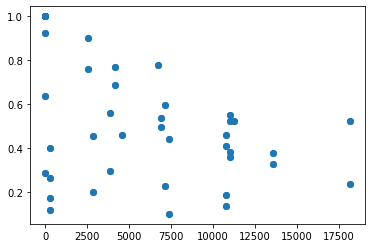

In [ ]:
for key in gauge_pairs_corr:
    print(key)
    print(len(df_sensors.loc[df_sensors.loc['STOD']]))

{'1473': {'1473': [0.0820667864274306,
   0.08494206530306446,
   0.08259674934912269,
   0.08332347250676511,
   0.08559919101513706,
   0.08851701476992728,
   0.09451788740170286,
   0.10203331054673885,
   0.10955754150409566,
   0.11461479859983043,
   0.12352555222707161,
   0.1353085177238702,
   0.15442493067186397,
   0.18067944637636846,
   0.21085477546368642,
   0.251761086963745,
   0.31327783657670344,
   0.4048715351590043,
   0.5226571510653925,
   0.7150020778845789,
   1.0,
   0.71500207788458,
   0.5226571510653927,
   0.4048715351590047,
   0.3132778365767036,
   0.2517610869637453,
   0.21085477546368644,
   0.1806794463763685,
   0.15442493067186414,
   0.13530851772387026,
   0.12352555222707144,
   0.11461479859983051,
   0.1095575415040958,
   0.10203331054673885,
   0.09451788740170264,
   0.08851701476992721,
   0.08559919101513701,
   0.08332347250676525,
   0.08259674934912246,
   0.08494206530306452],
  '1475': [0.030898294935410787,
   0.03346698681678247

# Rain-gauge drainage flow correlation

In [18]:
lag_values = range(-20,20)
corr_dict = {}
for drainage_name in df_target.columns:
    print(drainage_name)
    tmp_dict = {}
    for gauge_name in processed_gauges.columns:
        X_tmp = processed_gauges.loc[:,gauge_name]
        Y_tmp = df_target.loc[:,drainage_name]
        tmp_dict[gauge_name] = pair_lag_correlations(X_tmp,Y_tmp,lag_values)
    corr_dict[drainage_name] = tmp_dict

# this is just for a dict that can be turned into a dataframe
df_corr_all = pd.DataFrame(corr_dict)

RVK-SEI
RVK-BOD
RVK-VES
KOP-HAB
RVK-SKE
RVK-FAX
RVK-ANA
MOS-HOL


C:\Users\sverrirhd\Anaconda3\envs\gis_wradlib_torch\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\sverrirhd\Anaconda3\envs\gis_wradlib_torch\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


RVK-ING
RVK-LAU
RVK-GUF
RVK-GEL
RVK-KLE


# Selecting the subeset of data for which other weather observations are available

<AxesSubplot:>

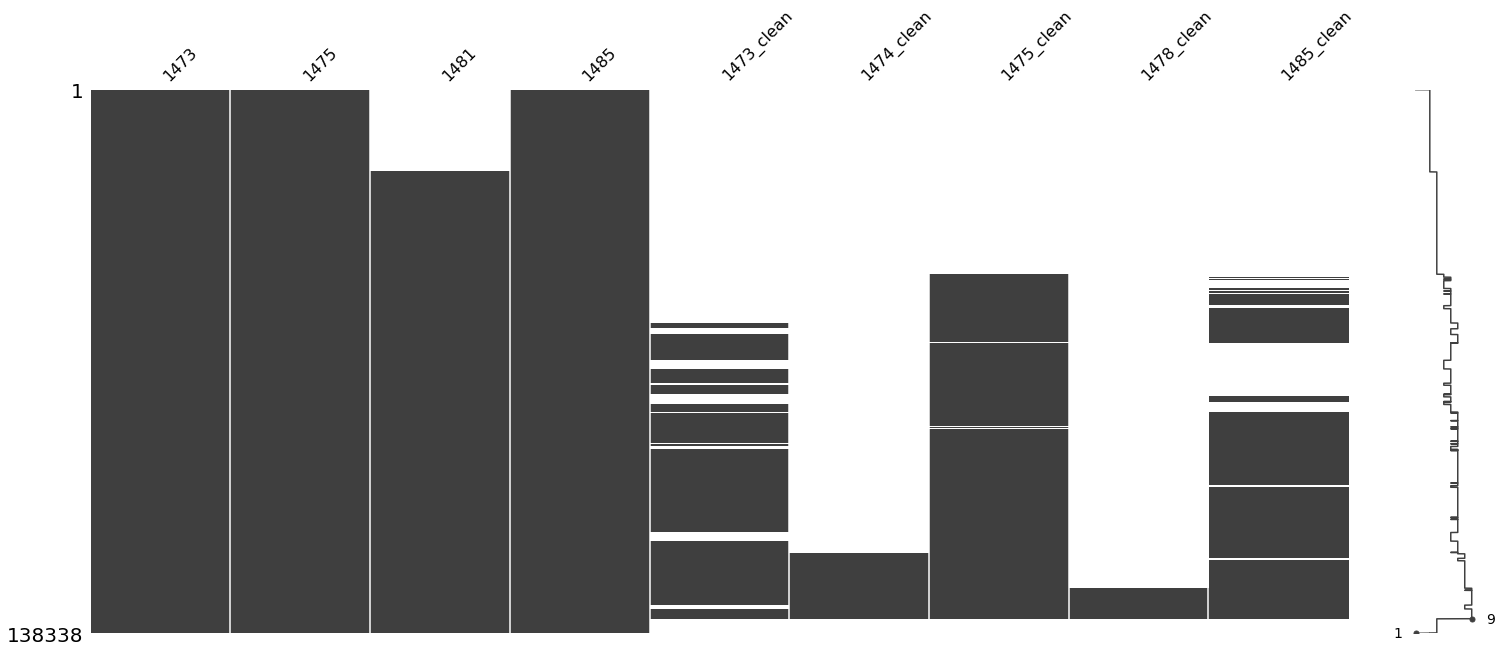

In [21]:
matrix(gauges)

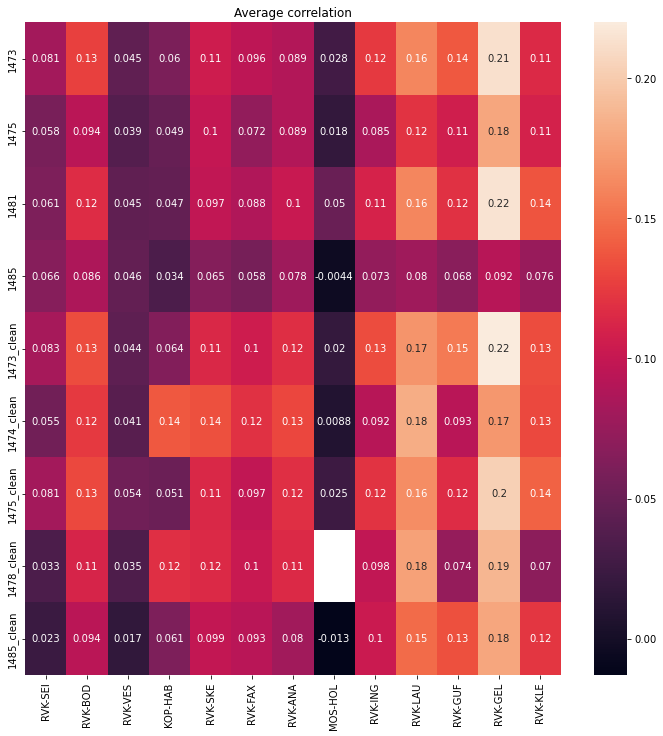

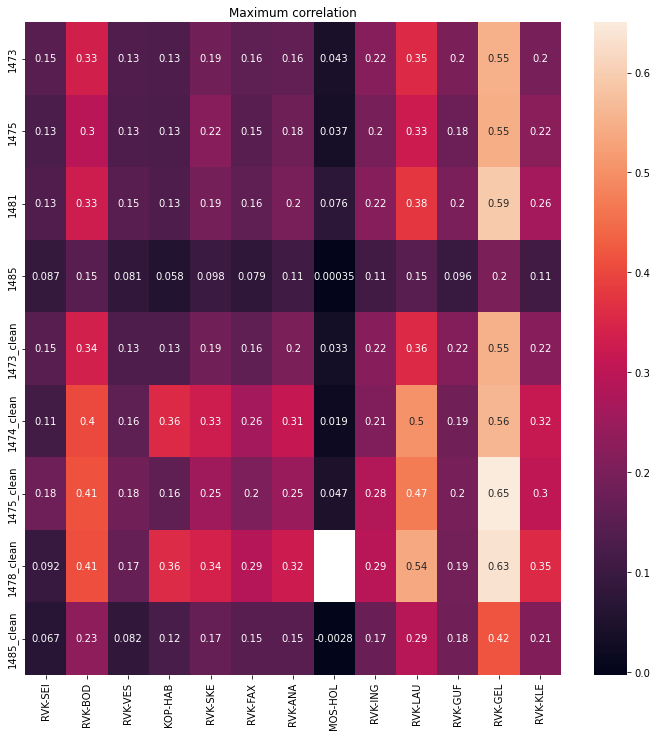

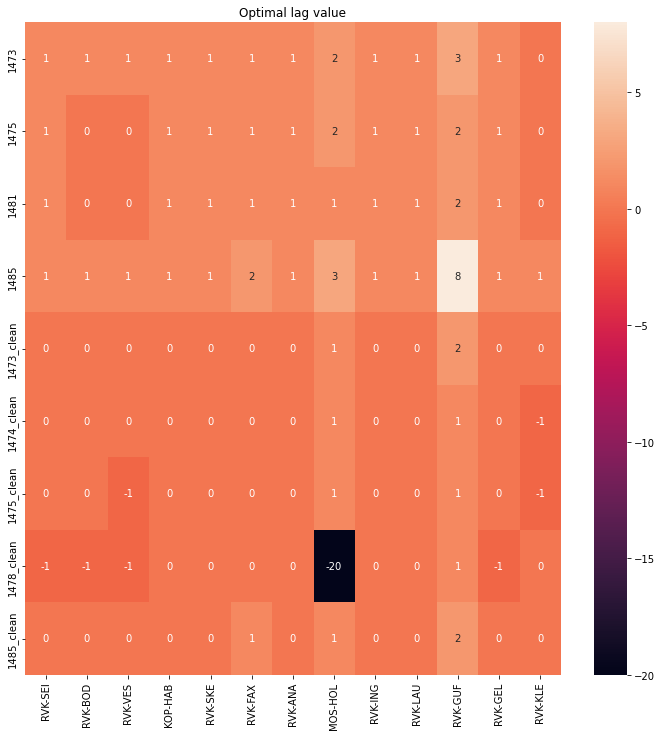

In [19]:
import seaborn as sns

plt.figure(figsize=(12,12))
sns.heatmap(df_corr_all.applymap(np.mean),annot=True)
plt.title('Average correlation')
plt.show()

plt.figure(figsize=(12,12))
sns.heatmap(df_corr_all.applymap(np.max),annot=True)
plt.title('Maximum correlation')
plt.show()

plt.figure(figsize=(12,12))
sns.heatmap(df_corr_all.applymap(lambda x : int(lag_values[np.argmax(x)])),annot=True)
plt.title('Optimal lag value')
plt.show()


# Let's use 1473 to predict for GEL


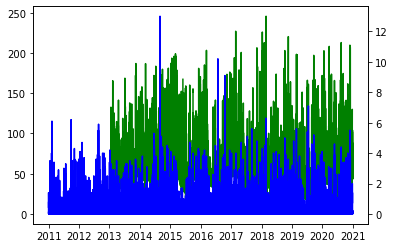

In [ ]:
# plt.plot(df_target.loc[:,'RVK-GEL'],color='green')
# plt.twinx().plot(gauges.loc[:,'1473'],color='blue')

drainage_sensor = 'RVK-BOD'
rain_gauge = '1475_clean'
plt.plot(df_target.loc[:,drainage_sensor],color='green')
plt.twinx().plot(processed_gauges.loc[:,rain_gauge],color='blue')

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from numpy.lib.stride_tricks import sliding_window_view


In [ ]:
# Model
lag = 12

def get_x_y_with_lag(lag,
                     input_data = gauges.loc[:,'1473'].resample('1h').sum(),
                     output_data = df_target.loc[:,'RVK-GEL'].resample('1h').sum(),
                     dt_start = datetime.datetime(2014,1,1,0,0,0),
                     dt_end = datetime.datetime(2020,12,31,23,59,59)):
    
    new_index = pd.date_range(dt_start,dt_end, freq='1h')
    common_index = input_data.index.intersection(output_data.index)
    
    # remove missing data
    input_data = input_data.loc[common_index]
    output_data = output_data.loc[common_index]
    input_data = input_data.dropna()
    output_data = output_data.dropna()
    # Replace with nan values in both datasets
    input_data = input_data.reindex(new_index)
    output_data = output_data.reindex(new_index)

    # Sliding window
    output_sequences = sliding_window_view(output_data,(lag)).squeeze()[:,-1]
    if (len(input_data.shape) == 1) or (input_data.shape[-1] == 1):
        rainfall_input_sequences = sliding_window_view(input_data,(lag)).reshape((-1,lag))
    else:
        rainfall_input_sequences = sliding_window_view(input_data,(lag,input_data.shape[-1])).reshape((-1,lag,input_data.shape[-1]))

    return rainfall_input_sequences,output_sequences


In [ ]:
# cycle_length = 24
# remove_cycle = lambda x,c : (np.nanmax([x[c],0]) + (x.diff(c).cumsum()/c).shift(-c))
# remove_season = lambda x : x - x.rolling(24*7*2,min_periods = 0).min()

Xg = processed_gauges.loc[:,'1475_clean'].resample('1h').sum()
Xw = pd.read_pickle('../../Rainfall - runoff/input_data').loc[:,['temperature','radiation','moist_pressure']]
X = pd.concat([Xw,Xg],axis=1).dropna()
Y = df_target.loc[:,'RVK-BOD'].resample('1h').sum()

lag = 1500
input_sequences,output_sequences =\
    get_x_y_with_lag(lag,
                     input_data = X,
                     output_data = Y,
                     dt_start = X.index.min(),
                     dt_end = datetime.datetime(2020,12,31,23,59,59))

# Comparing rainfall-runoff models

# Linear regression model on lagged values


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error

train_performance_dict = {}
test_performance_dict = {}
lag_values = np.arange(2,24*7*3,10)
alphas = np.logspace(-4,4,9)

for lag in lag_values:
    for alpha in alphas:
        # print('Using lag: ',lag)
        input_sequences_subset,output_sequences_subset = input_sequences[:,-lag:,-1],output_sequences
        n_train = int(len(input_sequences_subset)*0.5)
        # linreg = LinearRegression().fit(input_sequences_subset[:n_train], output_sequences_subset[:n_train])
        linreg = Ridge(alpha).fit(input_sequences_subset[:n_train], output_sequences_subset[:n_train])

        y_pred_train = linreg.predict(input_sequences_subset[:n_train]) 
        y_pred_test = linreg.predict(input_sequences_subset[n_train:]) 
        corr_func = lambda a,b : np.corrcoef(a,b)[0,1]
        corr_func.__name__ = 'Correlation'
        perf_list_train = {}
        perf_list_test = {}
        for metric in [mean_absolute_error,mean_squared_error,corr_func]:
            train_score = metric(output_sequences_subset[:n_train],y_pred_train)
            test_score = metric(output_sequences_subset[n_train:],y_pred_test)
            perf_list_train[metric.__name__] = train_score
            perf_list_test[metric.__name__] = test_score
            
        train_performance_dict[(lag,alpha)] = perf_list_train
        test_performance_dict[(lag,alpha)] = perf_list_test

NameError: name 'Ridge' is not defined

In [ ]:
# test_performance_dict

In [ ]:
pd.DataFrame(test_performance_dict).T.min(axis=0),pd.DataFrame(train_performance_dict).T.min(axis=0)


(mean_absolute_error      50.073496
 mean_squared_error     6171.096601
 Correlation               0.564562
 dtype: float64,
 mean_absolute_error      46.238736
 mean_squared_error     5355.330426
 Correlation               0.679008
 dtype: float64)

In [ ]:
test_scores = pd.DataFrame(test_performance_dict).T
train_scores = pd.DataFrame(train_performance_dict).T
for col in test_scores.columns:
    plt.plot(test_scores.loc[:,col])
    plt.plot(train_scores.loc[:,col])
    plt.title(col)
    plt.legend(['Test','Train'])
    plt.show()

# Gaussian process regression

In [ ]:
X = pd.concat([Xw,Xg],axis=1).dropna()
Y = df_target.loc[:,'RVK-GEL'].resample('1h').sum()

lag = 1500
input_sequences,output_sequences =\
    get_x_y_with_lag(lag,
                     input_data = X,
                     output_data = Y,
                     dt_start = X.index.min(),
                     dt_end = datetime.datetime(2020,12,31,23,59,59))

In [ ]:
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, RBF, RationalQuadratic, ExpSineSquared, ConstantKernel
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.svm import SVR
from sklearn.linear_model import *


In [ ]:

# X, y = make_friedman2(n_samples=500, noise=0, random_state=0)
kernel = DotProduct() + WhiteKernel() + RationalQuadratic()
#+ ExpSineSquared(100,24, periodicity_bounds='fixed')

validation_ratio = 0.5
lag = 168*2
# n_vars = 1
# X = input_sequences[:,-lag:,-1].reshape((-1,lag*n_vars))
# n_vars = 4
# X = input_sequences[:,-lag:].reshape((-1,lag*n_vars))
n_vars = 2
X = input_sequences[:,-lag:,[0,-1]]#.reshape((-1,lag*n_vars))
X = np.transpose(X,(0,2,1)).reshape(-1,2*lag)

# time_of_day = np.arange(0,len(output_sequences))%24
# X = np.c_[X,time_of_day]

y = output_sequences


n_train = int(len(X)*(1-validation_ratio))
X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]


n_subset = 2000 # 58/52 og GEL with 1000 and time of day
indexes = np.random.choice(len(X_train),n_subset)

gpr = GaussianProcessRegressor(kernel=kernel,
                               random_state=0,
                              #  alpha= 20,
                               ).fit(X_train[indexes],y_train[indexes])

# gpr = SVR('rbf', gamma  = 0.001).fit(X_train[indexes],y_train[indexes])

# gpr = Ridge(0).fit(X_train,y_train)
# gpr = ARDRegression().fit(X_train[indexes],y_train[indexes])

# Y_pred = gpr.predict(X, return_std=False)
Y_pred = gpr.predict(X)
print(np.mean(np.abs(Y_pred[:n_train] - y[:n_train])))
print(np.mean(np.abs(Y_pred[n_train:] - y[n_train:])))

C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


53.58968291743009
50.82488859573202


In [ ]:
# (y_train - pd.Series(y_train).rolling(24,0).mean()).abs().mean(),(y_test - pd.Series(y_test).rolling(24,0).mean()).abs().mean()
np.mean(np.abs((y_train - np.mean(y_train)))),np.mean(np.abs((y_test - np.mean(y_train))))


(67.7094453678003, 63.67845022607405)

In [ ]:
from sklearn.linear_model import Ridge, ARDRegression, LinearRegression

In [ ]:
# plt.plot(Y_pred[0])

In [ ]:
# X.shape,X_train.shape,n_train,y_train.shape,Y_pred.shape

In [ ]:
# plt.plot(input_sequences[0,-168:,0])
# plt.plot(input_sequences[0,-168:,-1])

In [ ]:
# plt.plot(X[0][::2])
# plt.plot(X[0][1::2])
# X[0].shape

In [ ]:
# # plt.scatter(X[:,-1],y)
# plt.scatter(X[:,-99],y)
# x_indexes = np.linspace(0,15,20)
# temp_indexes = np.linspace(0,15,20)

In [ ]:
gpr.score(X_test, y_test)

0.515766666166673

ValueError: x and y must be the same size

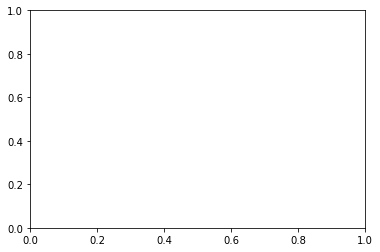

In [ ]:
plt.scatter(Y_pred,y_test)

In [ ]:
show = 10000
plt.plot(output_sequences[n_subset:n_subset + show])
plt.plot(Y_pred[n_subset:n_subset + show])
plt.show()

plt.plot(output_sequences[:n_subset])
plt.plot(Y_pred[:n_subset])
plt.show()

In [ ]:
plt.plot(output_sequences)
plt.plot(Y_pred)

NameError: name 'Y_pred_std' is not defined

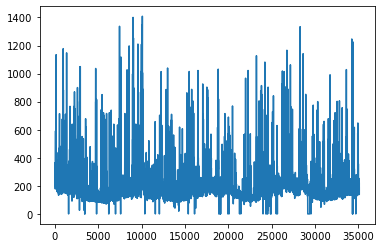

In [ ]:


plt.plot(output_sequences)
plt.fill_between(np.arange(len(output_sequences)),Y_pred + Y_pred_std,Y_pred - Y_pred_std,color='orange')
plt.plot()
plt.xlim(0,100)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(output_sequences)
plt.fill_between(np.arange(len(output_sequences)),Y_pred + Y_pred_std,Y_pred - Y_pred_std,color='orange')
plt.plot()
plt.xlim(1000,2000)
plt.show()



# Linear regression with extra variables

In [ ]:
input_sequences.shape

(35101, 1500, 4)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error

train_performance_dict = {}
test_performance_dict = {}
lag_values = np.arange(2,24*7,1)
for lag in lag_values:
    # print('Using lag: ',lag)
    input_sequences_subset,output_sequences_subset = input_sequences[:,-lag:].reshape(-1,lag*4),output_sequences
    # print(input_sequences_subset.shape)
    # input_sequences_subset,output_sequences_subset =\
    # get_x_y_with_lag(lag,
    #                  input_data = X,
    #                  output_data = Y,
    #                  dt_start = X.index.min(),
    #                  dt_end = datetime.datetime(2020,12,31,23,59,59))
    
    
    n_train = int(len(input_sequences_subset)*0.8)
    linreg = LinearRegression().fit(input_sequences_subset[:n_train], output_sequences_subset[:n_train])

    y_pred_train = linreg.predict(input_sequences_subset[:n_train]) 
    y_pred_test = linreg.predict(input_sequences_subset[n_train:]) 
    corr_func = lambda a,b : np.corrcoef(a,b)[0,1]
    corr_func.__name__ = 'Correlation'
    perf_list_train = {}
    perf_list_test = {}
    for metric in [mean_absolute_error,mean_squared_error,corr_func]:
        train_score = metric(output_sequences_subset[:n_train],y_pred_train)
        test_score = metric(output_sequences_subset[n_train:],y_pred_test)
        perf_list_train[metric.__name__] = train_score
        perf_list_test[metric.__name__] = test_score
        
    train_performance_dict[lag] = perf_list_train
    test_performance_dict[lag] = perf_list_test

In [ ]:
test_scores = pd.DataFrame(test_performance_dict).T
train_scores = pd.DataFrame(train_performance_dict).T
for col in test_scores.columns:
    plt.plot(test_scores.loc[:,col])
    plt.plot(train_scores.loc[:,col])
    plt.title(col)
    plt.legend(['Test','Train'])
    plt.show()

In [ ]:
lag = 2*168
input_sequences_subset,output_sequences_subset = input_sequences[:,-lag:].reshape(-1,lag*4),output_sequences
n_train = int(len(input_sequences_subset)*0.8)
linreg = LinearRegression().fit(input_sequences_subset[:n_train], output_sequences_subset[:n_train])

y_pred_train = linreg.predict(input_sequences_subset[:n_train]) 
y_pred_test = linreg.predict(input_sequences_subset[n_train:]) 
corr_func = lambda a,b : np.corrcoef(a,b)[0,1]
corr_func.__name__ = 'Correlation'
perf_list_train = {}
perf_list_test = {}
for metric in [mean_absolute_error,mean_squared_error,corr_func]:
    train_score = metric(output_sequences_subset[:n_train],y_pred_train)
    test_score = metric(output_sequences_subset[n_train:],y_pred_test)
    perf_list_train[metric.__name__] = train_score
    perf_list_test[metric.__name__] = test_score
print(perf_list_test,perf_list_train)

In [ ]:
test_scores

# Using LSTMs for temporal relationships

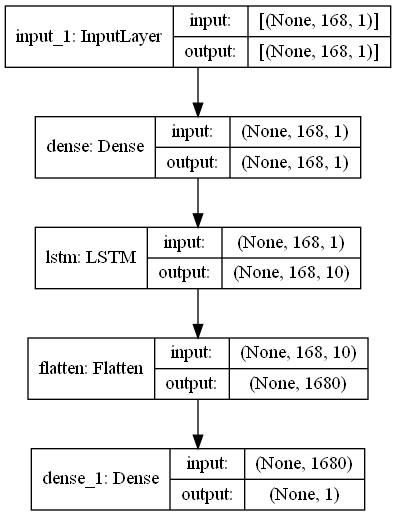

In [ ]:

val_ratio = 0.2
n_hidden = 10
lag = 24*7
# rainfall_input_sequences,output_sequences = get_x_y_with_lag(lag)

input = tf.keras.layers.Input((lag,1))
translate_0 = tf.keras.layers.Dense(1, activation='linear',use_bias=True)
states = tf.keras.layers.LSTM(n_hidden,
                            #   activation='linear',
                              return_sequences = True)
flatten = tf.keras.layers.Flatten()
output = tf.keras.layers.Dense(1, activation='linear',use_bias=True)


sequence = states(translate_0(input))
flat_seq = flatten(sequence)
final_output = output(flat_seq)
model = tf.keras.Model(input,final_output)

tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True)

In [ ]:

optimizer = tf.optimizers.Adam(learning_rate=0.01) #, clipnorm = 0.01)
model.compile(optimizer=optimizer,
              loss=tf.losses.MSE,
              metrics=[tf.keras.metrics.MAE,tf.losses.MSE,tfp.stats.correlation])


with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
    model.fit(input_sequences[:,-lag:,-1], output_sequences,
            validation_split = val_ratio,
            batch_size = 16,
            epochs = 10,
            shuffle=True,
            )

Epoch 1/10
1755/1755 [==============================] - 27s 13ms/step - loss: 10412.0596 - mean_absolute_error: 59.9492 - mean_squared_error: 10412.0596 - correlation: 0.4817 - val_loss: 7083.4487 - val_mean_absolute_error: 49.1048 - val_mean_squared_error: 7083.4487 - val_correlation: nan
Epoch 2/10
1755/1755 [==============================] - 24s 14ms/step - loss: 7874.4570 - mean_absolute_error: 54.6231 - mean_squared_error: 7874.4570 - correlation: 0.5677 - val_loss: 6416.8652 - val_mean_absolute_error: 50.8958 - val_mean_squared_error: 6416.8652 - val_correlation: nan
Epoch 3/10
1755/1755 [==============================] - 23s 13ms/step - loss: 7191.0581 - mean_absolute_error: 53.6440 - mean_squared_error: 7191.0581 - correlation: 0.5904 - val_loss: 5853.0176 - val_mean_absolute_error: 48.3960 - val_mean_squared_error: 5853.0176 - val_correlation: nan
Epoch 4/10
1755/1755 [==============================] - 23s 13ms/step - loss: 6798.9351 - mean_absolute_error: 52.8616 - mean_squar

# Using LSTMs with in addition to more weather data for potential hydrological modelling

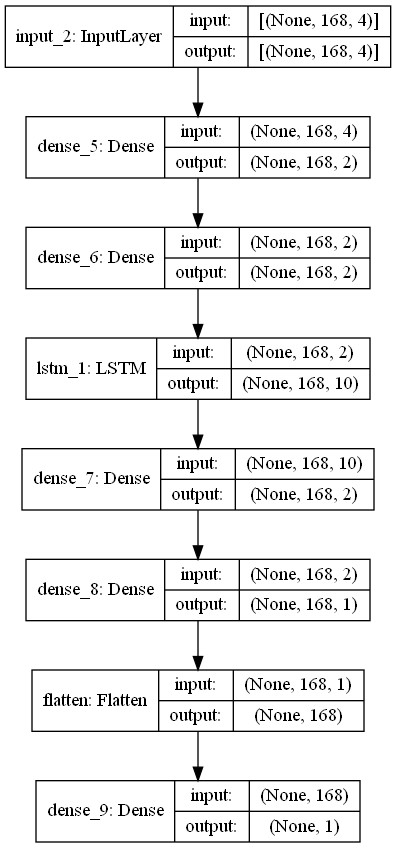

In [ ]:
val_ratio = 0.2
n_hidden = 10
lag = 168
input = tf.keras.layers.Input((lag,input_sequences.shape[-1]))
translate_0 = tf.keras.layers.Dense(2, activation='relu')
translate_1 = tf.keras.layers.Dense(2, activation='relu')
states = tf.keras.layers.LSTM(n_hidden,
                            #   activation='linear',
                              return_sequences = True,
                              )
flatten = tf.keras.layers.Flatten()
retranslate_0 = tf.keras.layers.Dense(2, activation='relu')
retranslate_1 = tf.keras.layers.Dense(1, activation='relu')
# flatten = tf.keras.layers.Flatten()
output = tf.keras.layers.Dense(1, activation='linear')

model = tf.keras.Model(input,output(flatten(retranslate_1(retranslate_0(states(translate_1(translate_0(input))))))))

tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True)


In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=0.01) #, clipnorm = 0.01)
model.compile(optimizer=optimizer,
              loss=tf.losses.MSE,
              metrics=[tf.keras.metrics.MAE,tf.losses.MSE,tfp.stats.correlation])


with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
    model.fit(input_sequences[:,-lag:], output_sequences,
            validation_split = val_ratio,
            batch_size = 16,
            epochs = 10,
            shuffle=True,
            )

Epoch 1/10
1755/1755 [==============================] - 32s 16ms/step - loss: 11259.1592 - mean_absolute_error: 57.9263 - mean_squared_error: 11259.1592 - correlation: 0.4776 - val_loss: 11223.9453 - val_mean_absolute_error: 54.1043 - val_mean_squared_error: 11223.9453 - val_correlation: nan
Epoch 2/10
1755/1755 [==============================] - 24s 14ms/step - loss: 10438.7393 - mean_absolute_error: 54.7433 - mean_squared_error: 10438.7393 - correlation: 0.5255 - val_loss: 10563.6318 - val_mean_absolute_error: 52.2812 - val_mean_squared_error: 10563.6318 - val_correlation: nan
Epoch 3/10
1755/1755 [==============================] - 21s 12ms/step - loss: 8439.0625 - mean_absolute_error: 51.4867 - mean_squared_error: 8439.0625 - correlation: 0.6273 - val_loss: 8134.3462 - val_mean_absolute_error: 50.9044 - val_mean_squared_error: 8134.3462 - val_correlation: nan
Epoch 4/10
1755/1755 [==============================] - 23s 13ms/step - loss: 6132.4258 - mean_absolute_error: 46.6198 - mean

In [ ]:

optimizer = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=tf.losses.MSE,
              metrics=[tf.keras.metrics.MAE,tf.losses.MSE,tfp.stats.correlation])

with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
    model.fit(input_sequences[:,-lag:], output_sequences,
            validation_split = val_ratio,
            batch_size = 16,
            epochs = 5,
            shuffle=True,
            )

Epoch 1/5
1755/1755 [==============================] - 27s 14ms/step - loss: 5190.4229 - mean_absolute_error: 44.4317 - mean_squared_error: 5190.4229 - correlation: 0.6902 - val_loss: 5429.1313 - val_mean_absolute_error: 42.5812 - val_mean_squared_error: 5429.1313 - val_correlation: nan
Epoch 2/5
1755/1755 [==============================] - 23s 13ms/step - loss: 4107.9946 - mean_absolute_error: 39.1785 - mean_squared_error: 4107.9946 - correlation: 0.7568 - val_loss: 3975.3423 - val_mean_absolute_error: 38.0471 - val_mean_squared_error: 3975.3423 - val_correlation: nan
Epoch 3/5
1755/1755 [==============================] - 22s 13ms/step - loss: 3913.5334 - mean_absolute_error: 38.6908 - mean_squared_error: 3913.5334 - correlation: 0.7673 - val_loss: 3742.0952 - val_mean_absolute_error: 37.8542 - val_mean_squared_error: 3742.0952 - val_correlation: nan
Epoch 4/5
1755/1755 [==============================] - 24s 14ms/step - loss: 3864.4607 - mean_absolute_error: 38.5361 - mean_squared_err

In [ ]:

optimizer = tf.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss=tf.losses.MSE,
              metrics=[tf.keras.metrics.MAE,tf.losses.MSE,tfp.stats.correlation])

with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
    model.fit(input_sequences[:,-lag:], output_sequences,
            validation_split = val_ratio,
            batch_size = 16,
            epochs = 10,
            shuffle=True,
            )

Epoch 1/10
1755/1755 [==============================] - 25s 13ms/step - loss: 3740.5044 - mean_absolute_error: 38.0661 - mean_squared_error: 3740.5044 - correlation: 0.7730 - val_loss: 4098.9873 - val_mean_absolute_error: 38.9018 - val_mean_squared_error: 4098.9873 - val_correlation: nan
Epoch 2/10
1755/1755 [==============================] - 22s 13ms/step - loss: 3732.9885 - mean_absolute_error: 38.0008 - mean_squared_error: 3732.9885 - correlation: 0.7702 - val_loss: 3740.5486 - val_mean_absolute_error: 37.4907 - val_mean_squared_error: 3740.5486 - val_correlation: nan
Epoch 3/10
1755/1755 [==============================] - 22s 12ms/step - loss: 3713.0164 - mean_absolute_error: 37.9247 - mean_squared_error: 3713.0164 - correlation: 0.7734 - val_loss: 3790.2888 - val_mean_absolute_error: 37.7491 - val_mean_squared_error: 3790.2888 - val_correlation: nan
Epoch 4/10
1755/1755 [==============================] - 24s 14ms/step - loss: 3672.7405 - mean_absolute_error: 37.7601 - mean_squared

In [ ]:
n_train08 = int(len(output_sequences) * 0.8)
y_pred = model.predict(input_sequences[n_train08:,-lag:,])

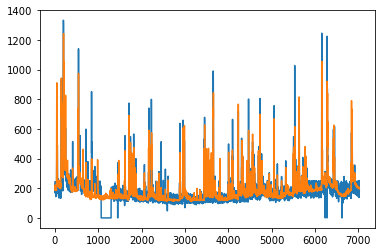

In [ ]:
plt.plot(output_sequences[n_train08:])
plt.plot(y_pred)